# Problem Definition
In this Reinforcement Learning framework for trading strategy, the algorithm takes an action (buy, sell or hold) depending upon the current state of the stock price. The algorithm is trained using Q-Learning framework, to help us predict the best action, based on the current stock prices.

### The key components of the RL based framework are :

**Agent**: Trading agent.

**Action:** Buy, sell or hold.

**Reward function:** Realized profit and loss (PnL) is used as the reward function for this case study. The reward depends upon the action:

**Sell:** Realized profit and loss (sell price - bought price)

**Buy:** No reward

**Hold:** No Reward

**State:** Differences of past stock prices for a given time window is used as the state.

*The data used for this case study will be the standard and poor's 500. The link to the data is : https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC).*

# Loading the Libraries and Data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random


#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

In [2]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('/content/SP500.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

In [5]:
# shape
dataset.shape

(2516, 6)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

Open         High          Low        Close    Adj Close      Volume
Date                                                                                   
2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990  1132.989990  3991400000
2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020  2491020000
2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015  1137.140015  4972660000
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941  5270680000
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980  4389590000

In [7]:
# describe data
# Set precision for DataFrame display
pd.set_option('display.precision', 3)

# Describe data
dataset.describe()


Open      High       Low     Close  Adj Close     Volume
count  2516.000  2516.000  2516.000  2516.000   2516.000  2.516e+03
mean   1962.148  1971.347  1952.200  1962.609   1962.609  3.715e+09
std     589.031   590.191   587.624   588.910    588.910  8.134e+08
min    1027.650  1032.950  1010.910  1022.580   1022.580  1.025e+09
25%    1381.643  1390.700  1372.800  1384.405   1384.405  3.238e+09
50%    1985.320  1993.085  1975.660  1986.480   1986.480  3.588e+09
75%    2434.180  2441.523  2427.960  2433.968   2433.968  4.077e+09
max    3247.230  3247.930  3234.370  3240.020   3240.020  1.062e+10

<Axes: xlabel='Date'>

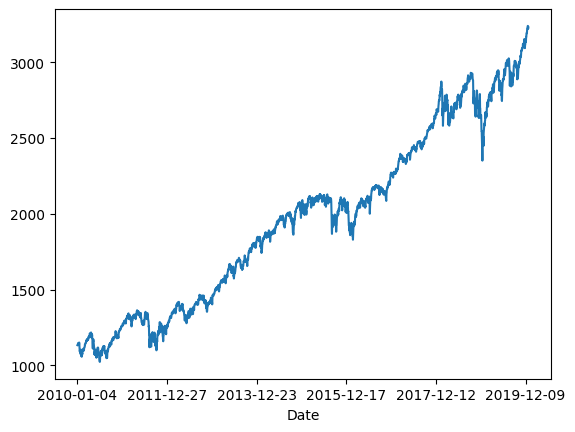

In [8]:
dataset['Close'].plot()

# Data Preprocessing

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [10]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

Open     High      Low    Close  Adj Close      Volume
Date                                                                 
2010-01-04  1116.56  1133.87  1116.56  1132.99    1132.99  3991400000
2010-01-05  1132.66  1136.63  1129.66  1136.52    1136.52  2491020000

#Training and Testing Data Split

In [11]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [12]:
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

# Implementation Steps For Designing a Reinforcement learning model
•	Importing Libraries

•	Create the agent who will make all decisions

•	Define basic functions for formatting the values, sigmoid function, reading the data file, etc

•	Train the agent

•	Evaluate the agent performance


In [1]:
#Agent in the environment
import numpy as np
import random
from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size  #state vector size typically refers to the number of features or dimensions used to represent each state, not the number of data points.
        self.action_size = 3          #buy,sell,hold
        self.memory = deque(maxlen=1000)  # Initialize a memory buffer to store past experiences
        self.inventory = []                # Initialize an inventory to track bought stocks
        self.model_name = model_name       # Set the name of the model file to load or save
        self.is_eval = is_eval             # Flag to indicate if the agent is in evaluation mode
        self.gamma = 0.95                  # Set the discount factor for future rewards
        self.epsilon = 1.0                 # Set the exploration rate (epsilon) for epsilon-greedy strategy
        # self.epsilon_min = 0.01
        # self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        #add input layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #add hidden layer
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #add output layer
        model.add(Dense(self.action_size, activation="linear"))
        # Compile the model with mean squared error loss and Adam optimizer
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model

#epsilon-greedy approch is implemented to find action
    def act(self, state):
        # If in evaluation mode or with probability epsilon, choose a random action
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        #exploitation
        # Otherwise, predict Q-values for each action and choose the action with the highest Q-value
        options = self.model.predict(state)
        return np.argmax(options[0])


    # def expReplay(self, batch_size):
    #     mini_batch = []
    #     l = len(self.memory)
    #     for i in range(l - batch_size + 1, l):
    #         mini_batch.append(self.memory[i])

    #     for state, action, reward, next_state, done in mini_batch:
    #         target = reward
    #         if not done:
    #             target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
    #         target_f = self.model.predict(state)
    #         target_f[0][action] = target
    #         self.model.fit(state, target_f, epochs=1, verbose=0)

    #     if self.epsilon > self.epsilon_min:
    #         self.epsilon *= self.epsilon_decay


In [15]:
#Helper functions
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
#This ensures that the state representation always consists of n consecutive closing prices,
# even if it requires padding with the initial closing price.
def getState(data, t, n): # n is window size and t is at time t
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

# Training

Running episode 0/100
--------------------------------
Total Profit: $52768.01
--------------------------------


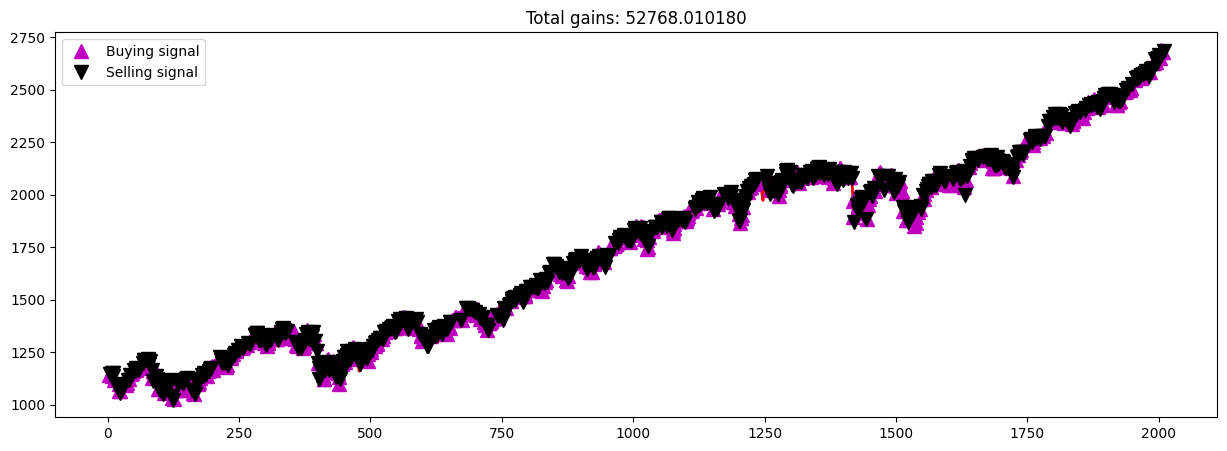

Running episode 1/100
--------------------------------
Total Profit: $44671.78
--------------------------------


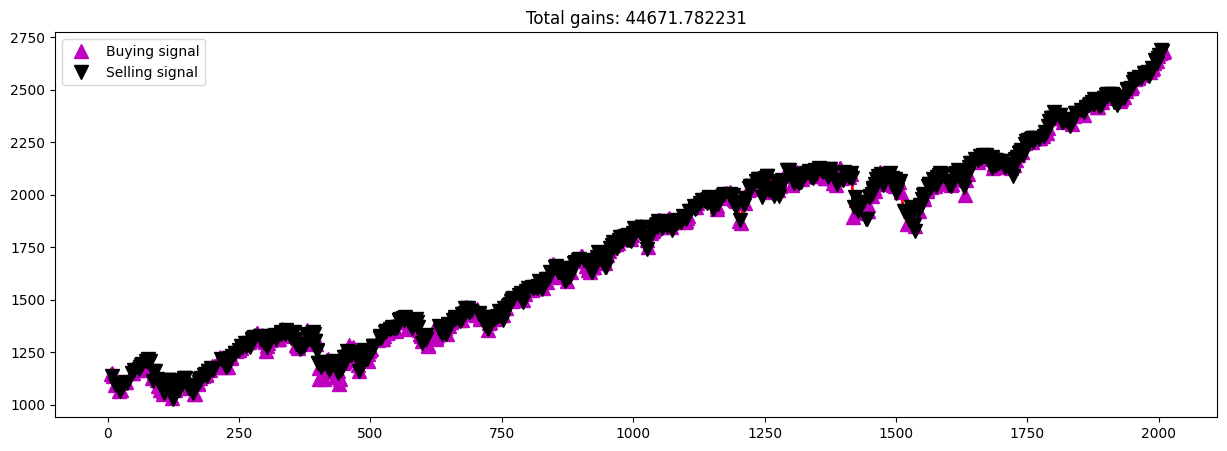

Running episode 2/100
--------------------------------
Total Profit: $8510.55
--------------------------------


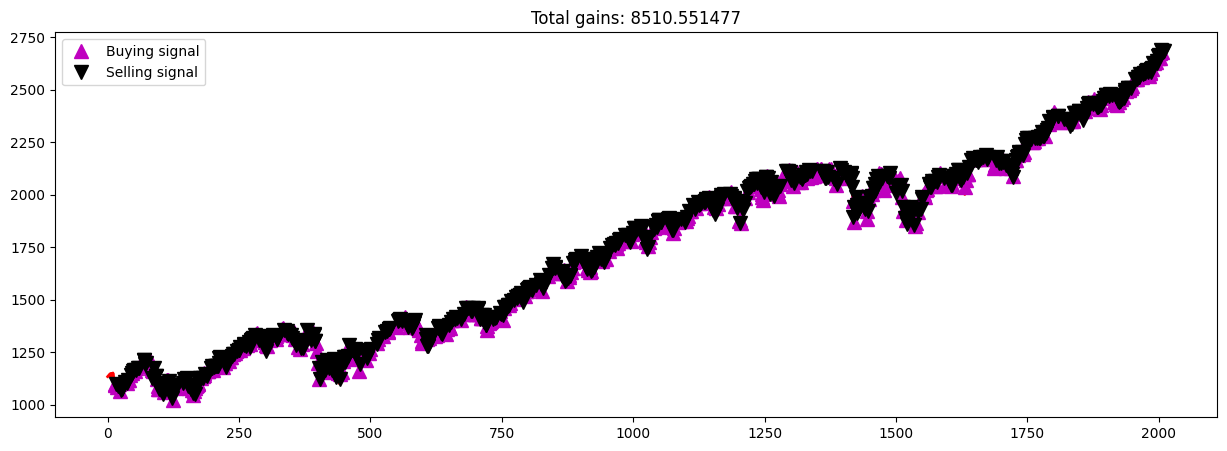

Running episode 3/100
--------------------------------
Total Profit: $34117.91
--------------------------------


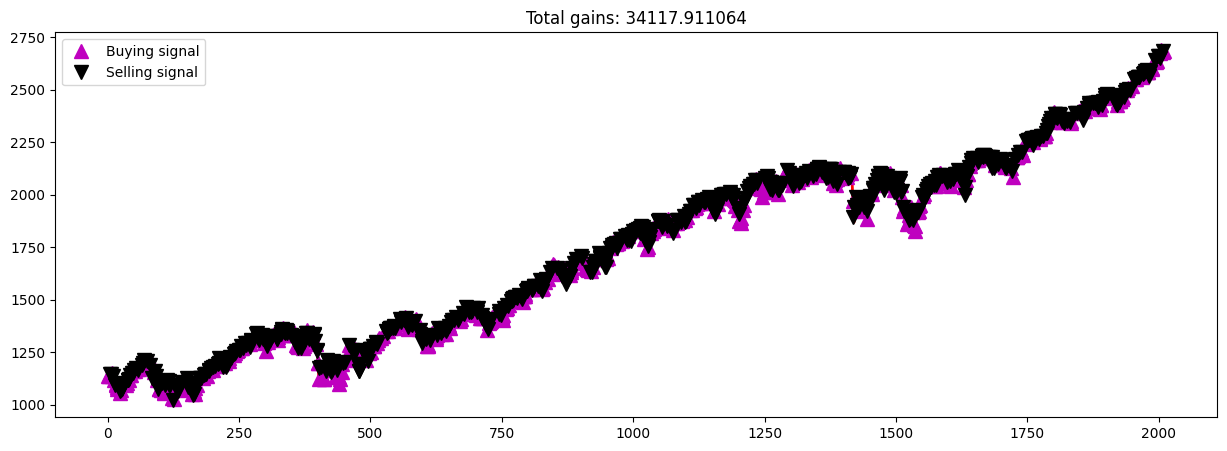

Running episode 4/100
--------------------------------
Total Profit: $19221.75
--------------------------------


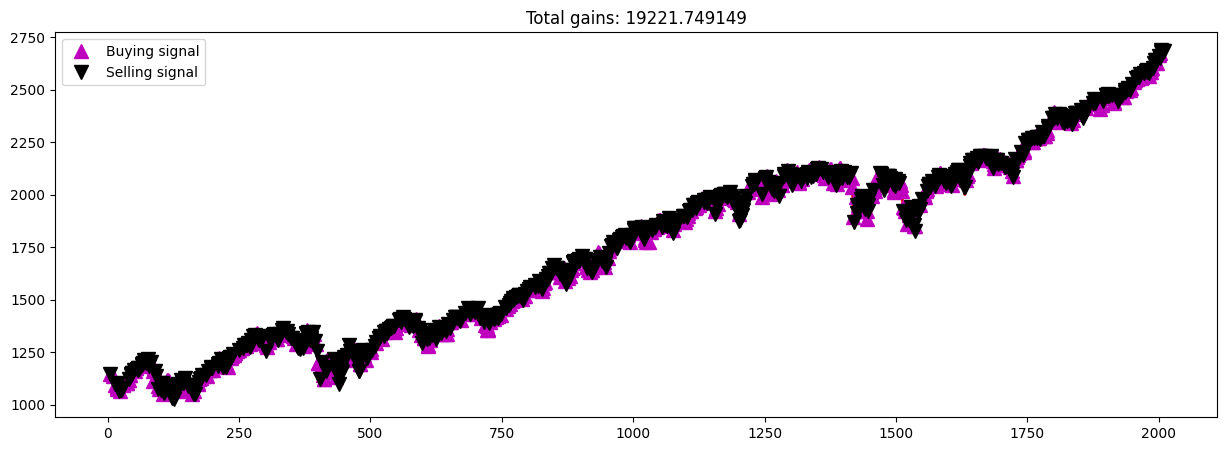

Running episode 5/100
--------------------------------
Total Profit: $26881.69
--------------------------------


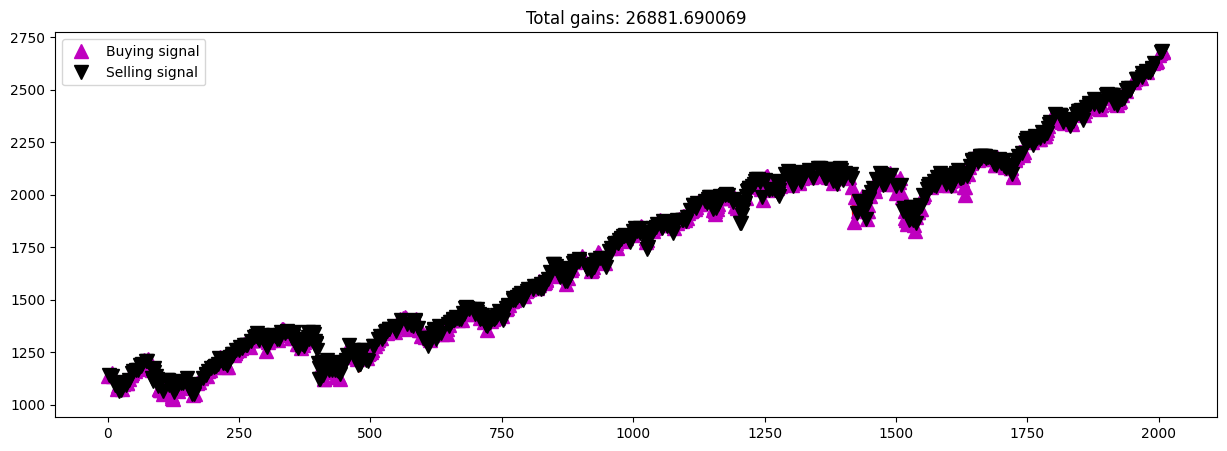

Running episode 6/100
--------------------------------
Total Profit: $41760.96
--------------------------------


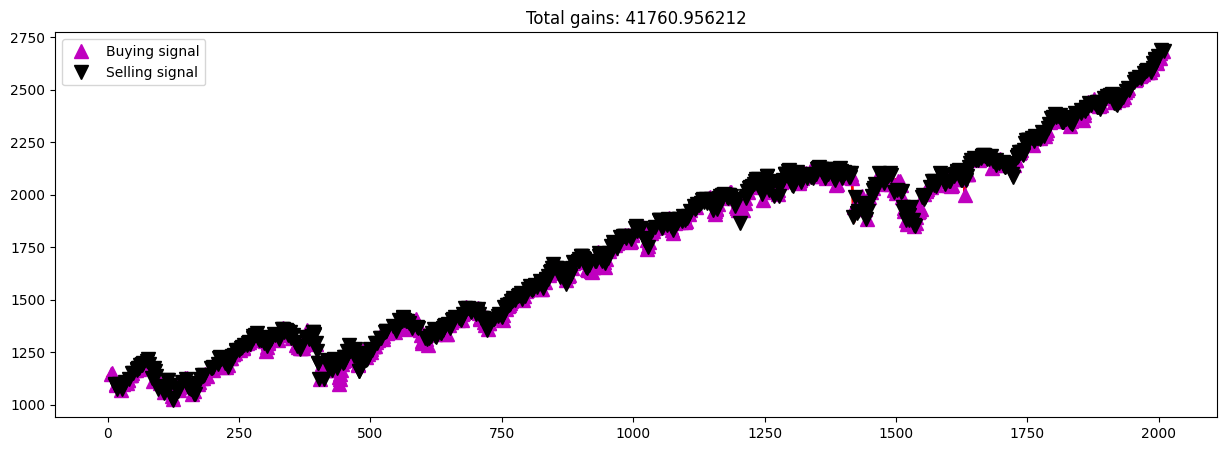

Running episode 7/100
--------------------------------
Total Profit: $28921.66
--------------------------------


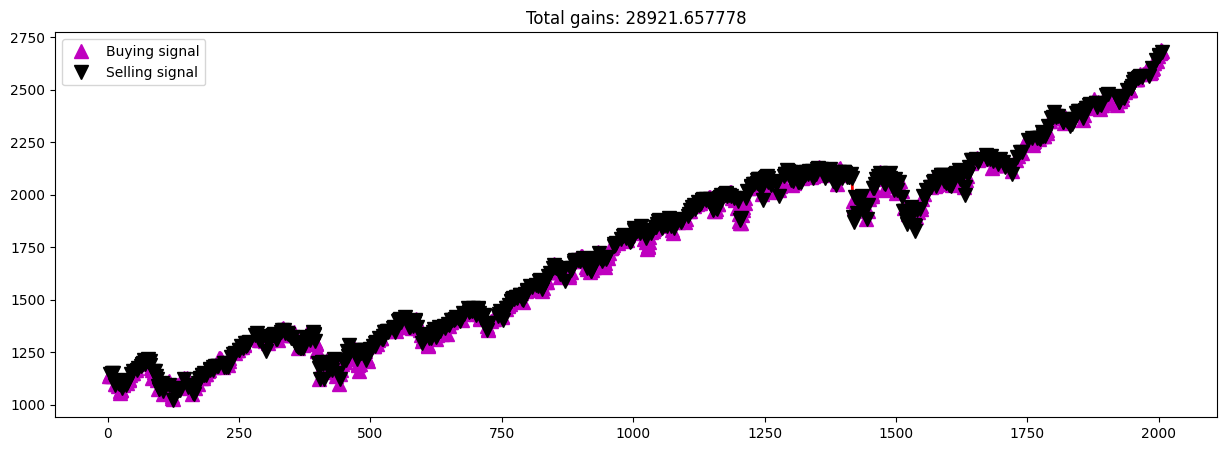

Running episode 8/100
--------------------------------
Total Profit: $14475.24
--------------------------------


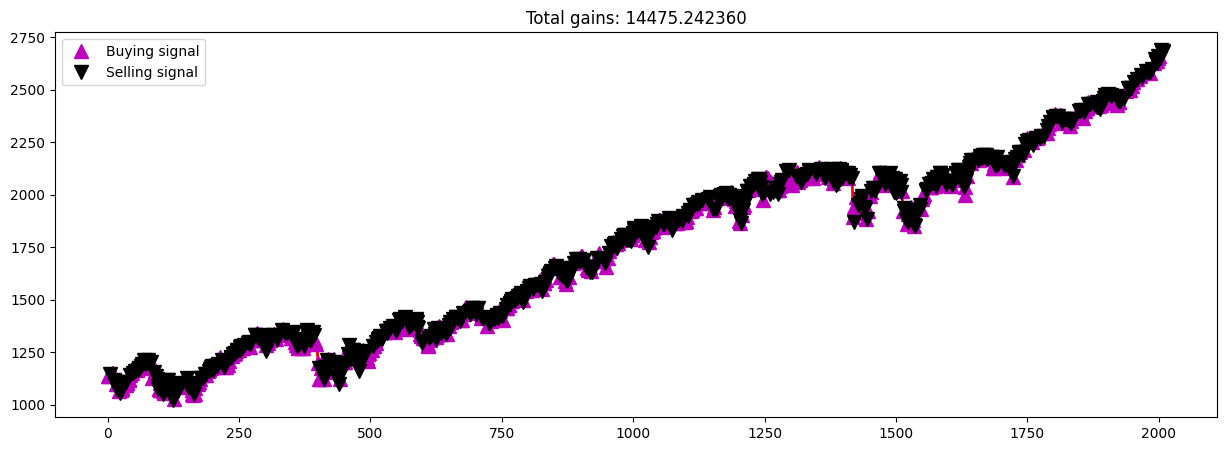

Running episode 9/100
--------------------------------
Total Profit: $9112.01
--------------------------------


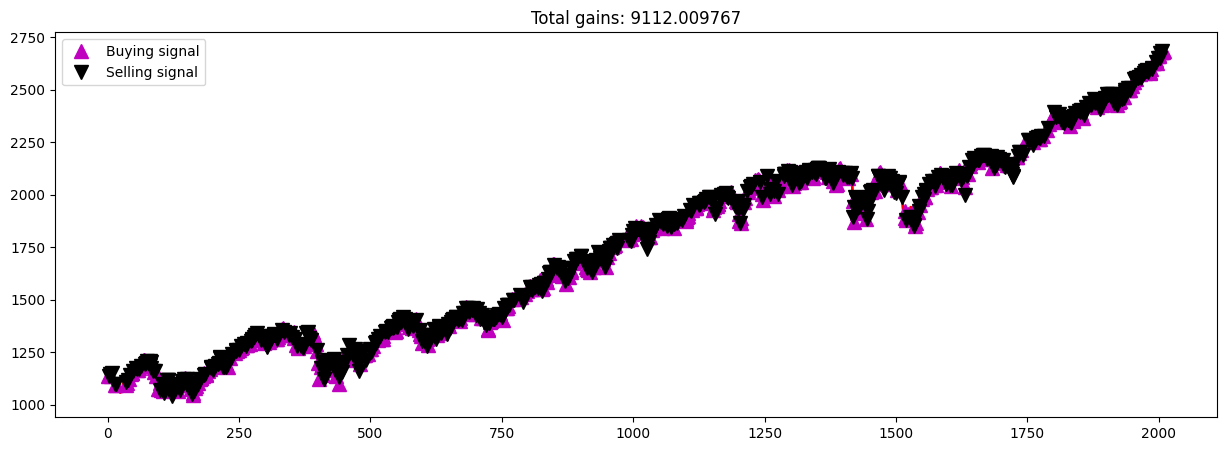

Running episode 10/100
--------------------------------
Total Profit: $45652.34
--------------------------------


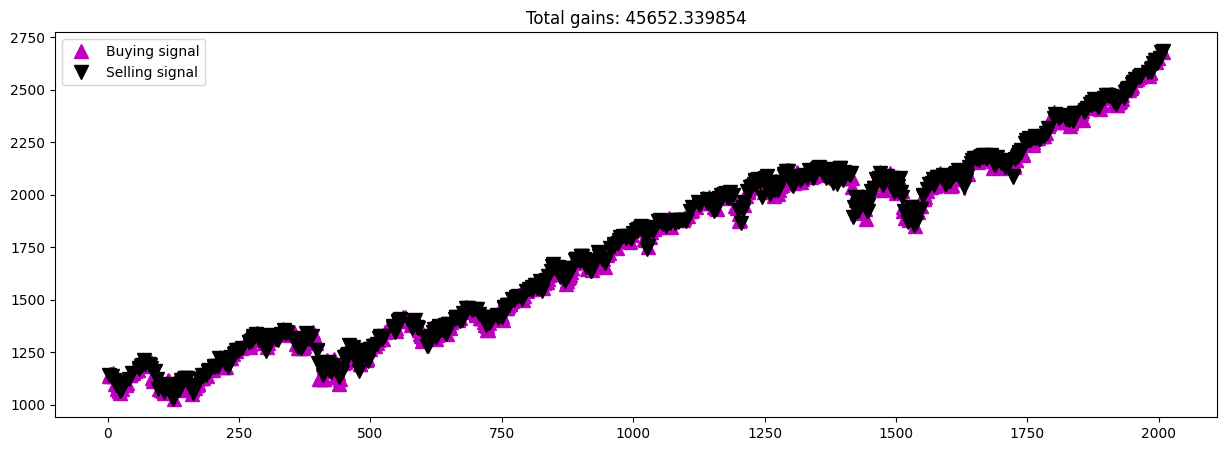

Running episode 11/100
--------------------------------
Total Profit: $18279.62
--------------------------------


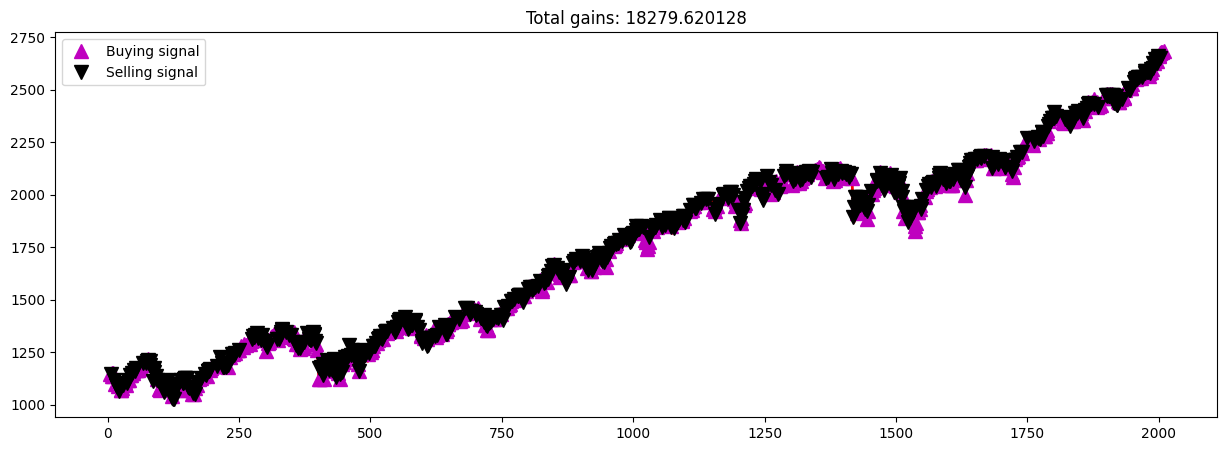

Running episode 12/100
--------------------------------
Total Profit: $22271.40
--------------------------------


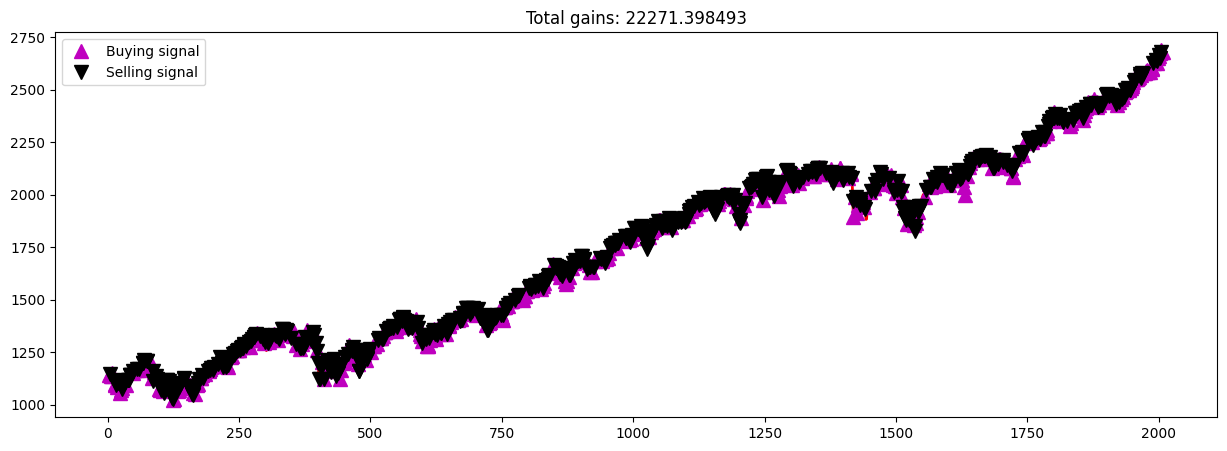

Running episode 13/100
--------------------------------
Total Profit: $20937.20
--------------------------------


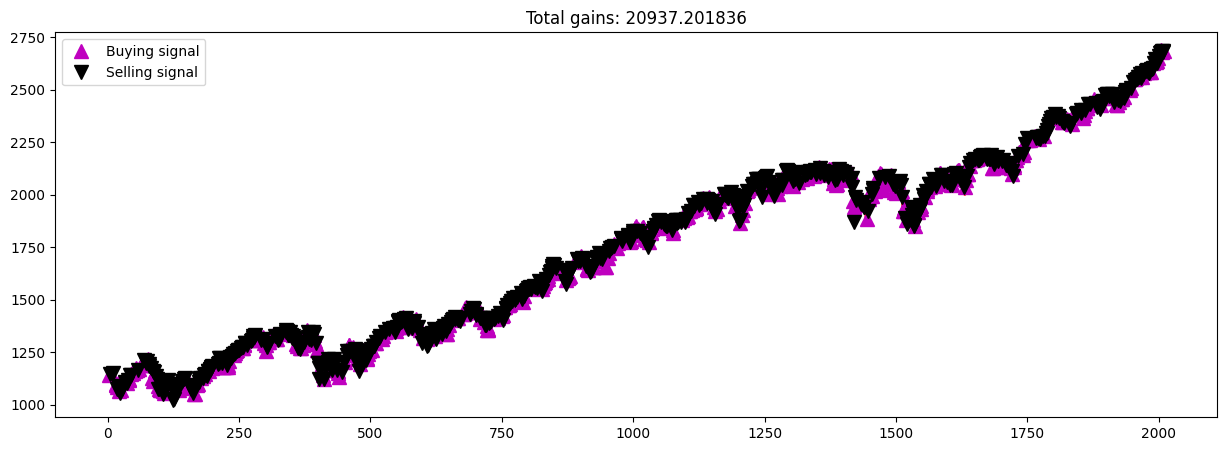

Running episode 14/100
--------------------------------
Total Profit: $17279.03
--------------------------------


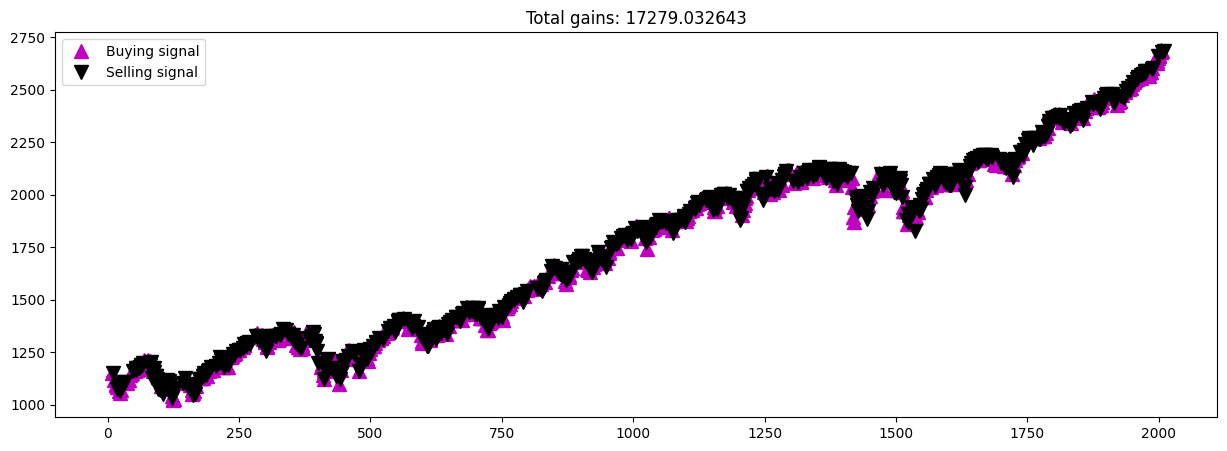

Running episode 15/100
--------------------------------
Total Profit: $60136.12
--------------------------------


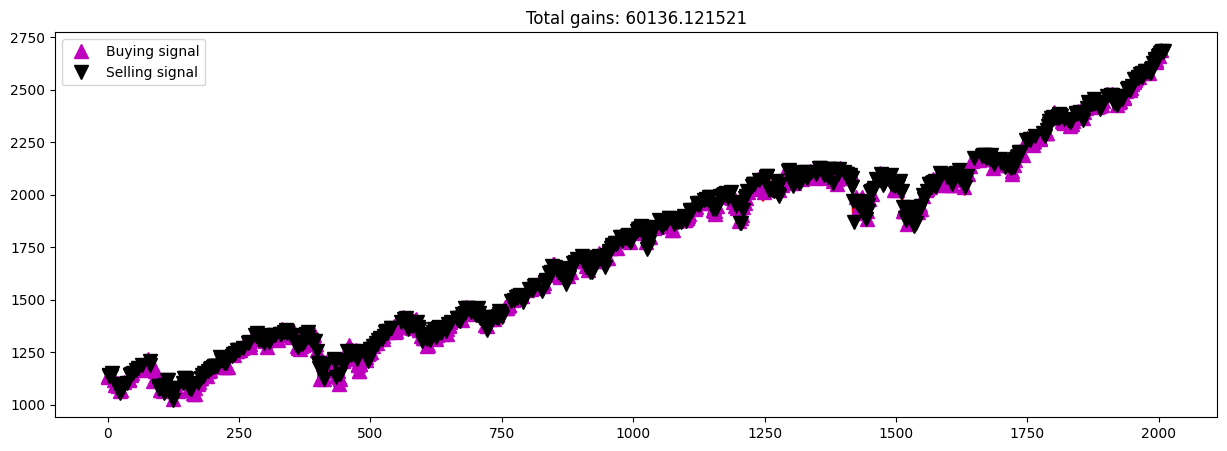

Running episode 16/100
--------------------------------
Total Profit: $26977.09
--------------------------------


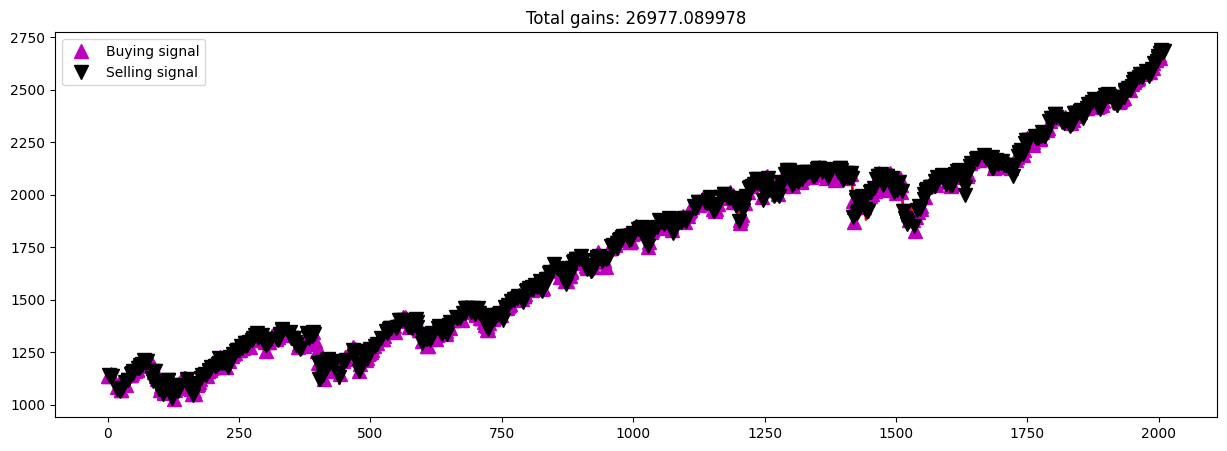

Running episode 17/100
--------------------------------
Total Profit: $22035.17
--------------------------------


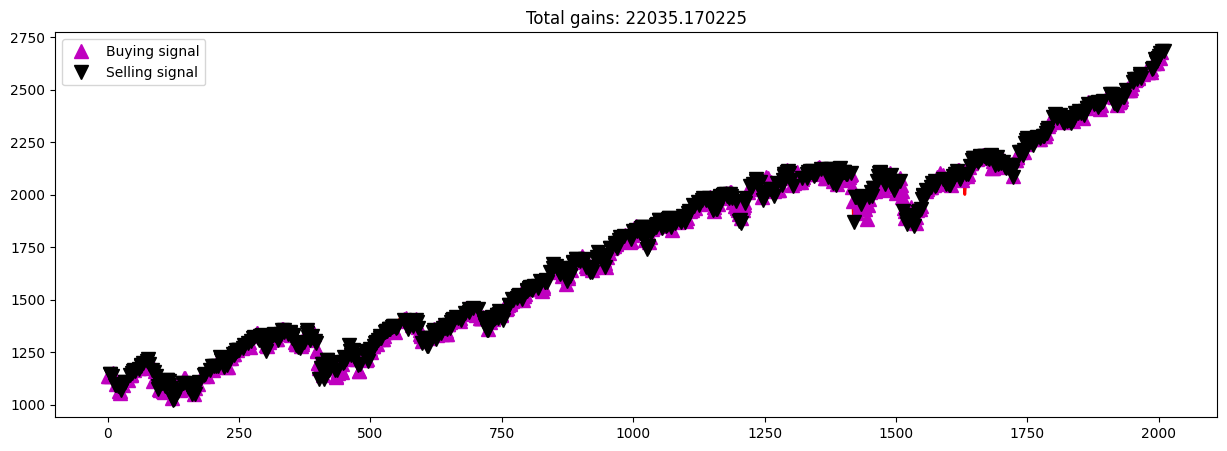

Running episode 18/100
--------------------------------
Total Profit: $10152.43
--------------------------------


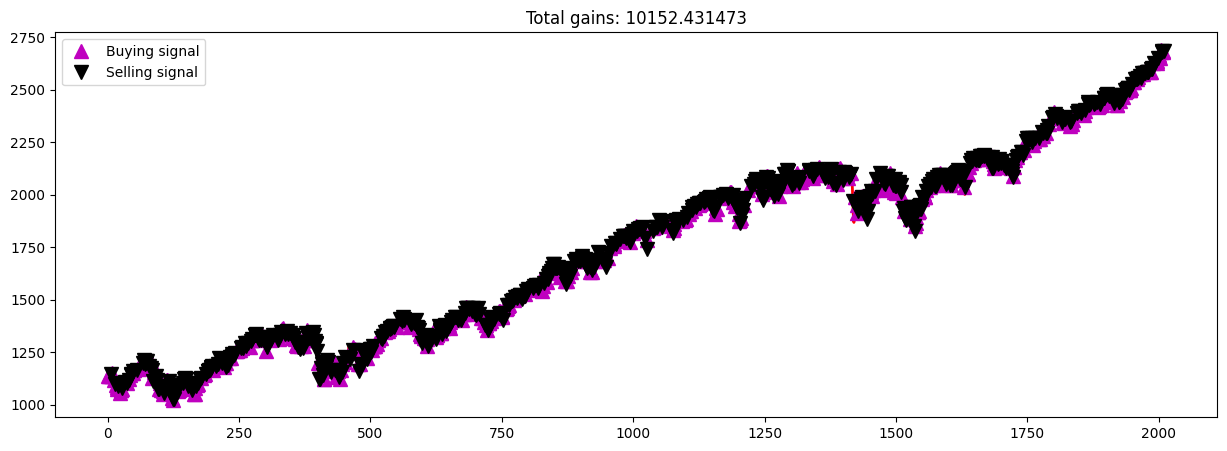

Running episode 19/100
--------------------------------
Total Profit: $12430.81
--------------------------------


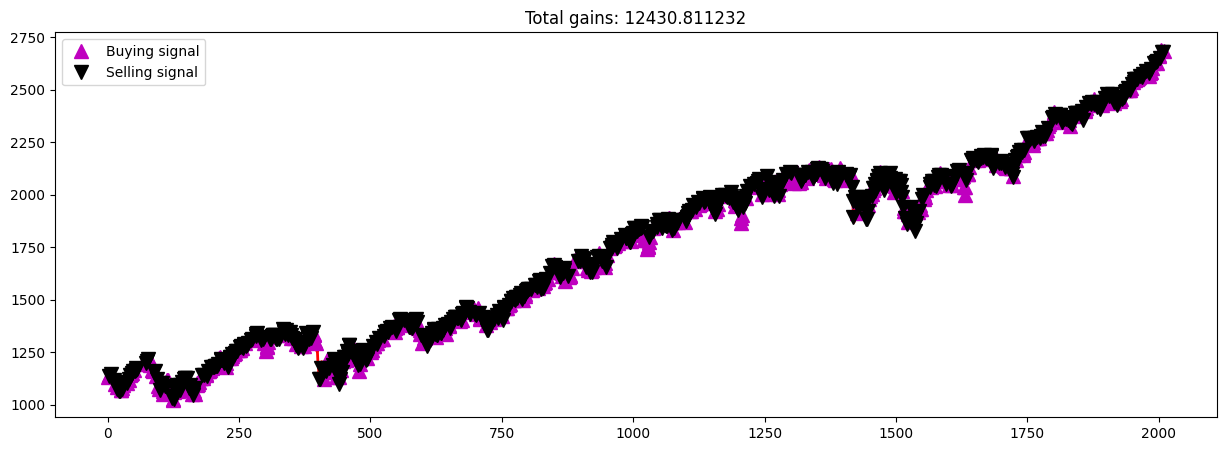

Running episode 20/100
--------------------------------
Total Profit: $31407.95
--------------------------------


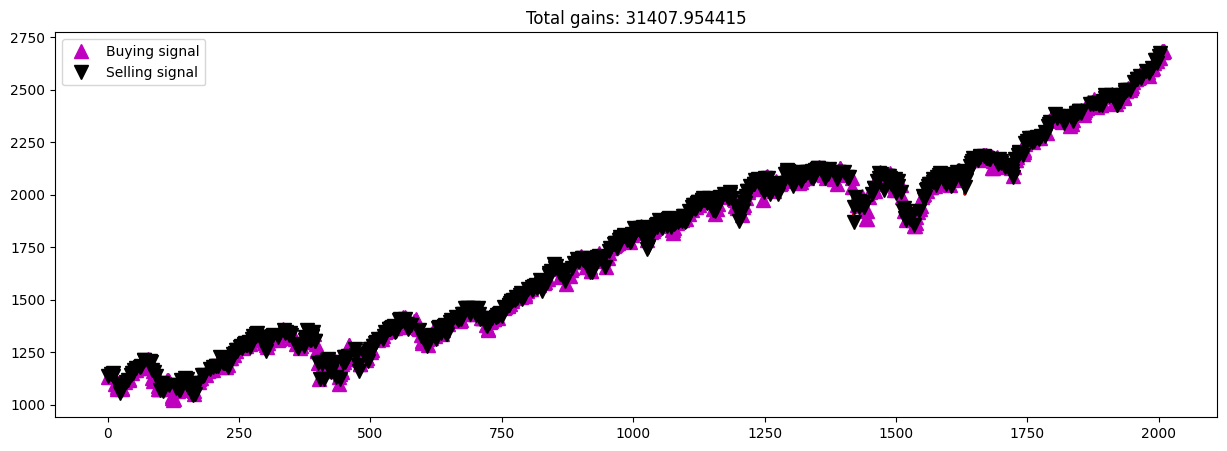

Running episode 21/100
--------------------------------
Total Profit: $14800.13
--------------------------------


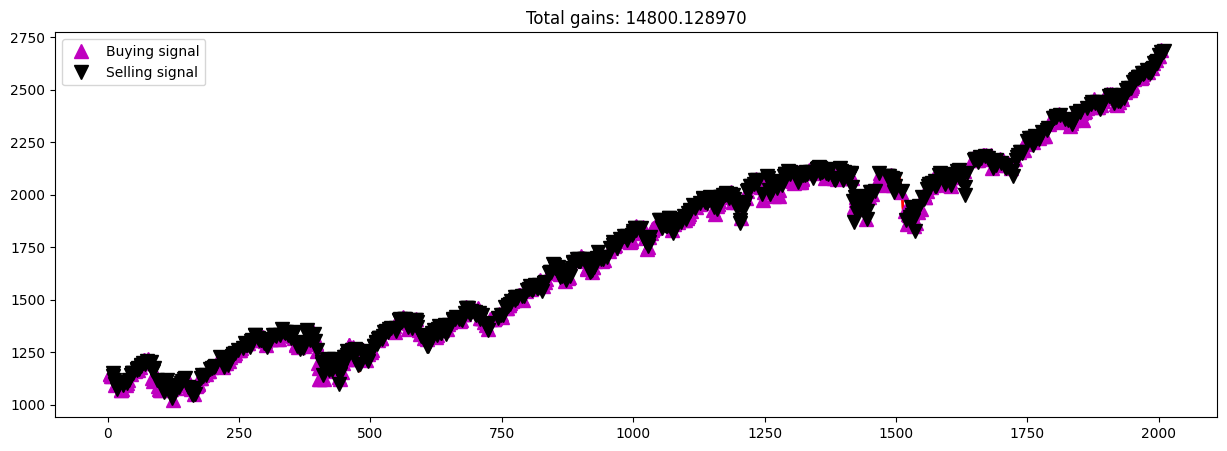

Running episode 22/100
--------------------------------
Total Profit: $49002.21
--------------------------------


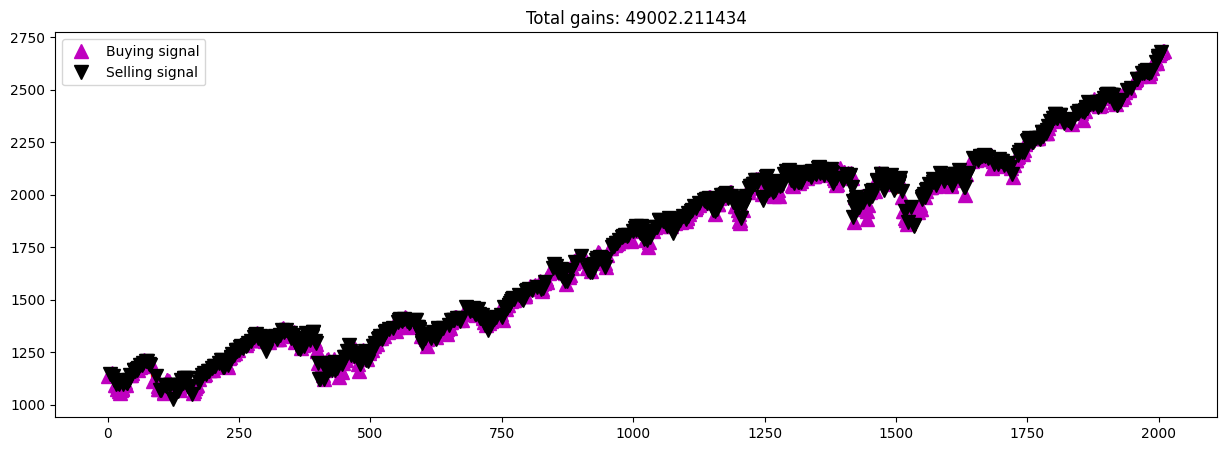

Running episode 23/100
--------------------------------
Total Profit: $23883.69
--------------------------------


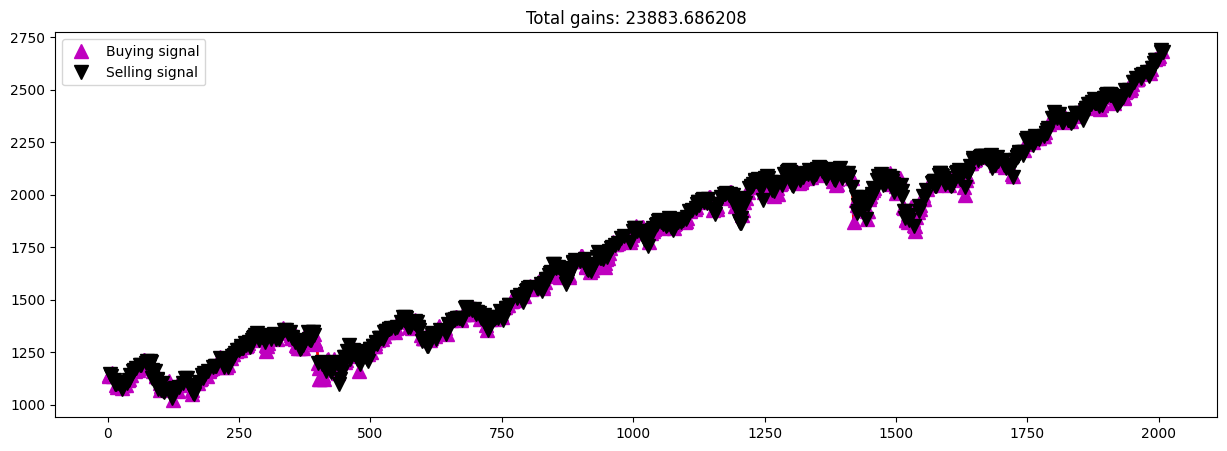

Running episode 24/100
--------------------------------
Total Profit: $80801.05
--------------------------------


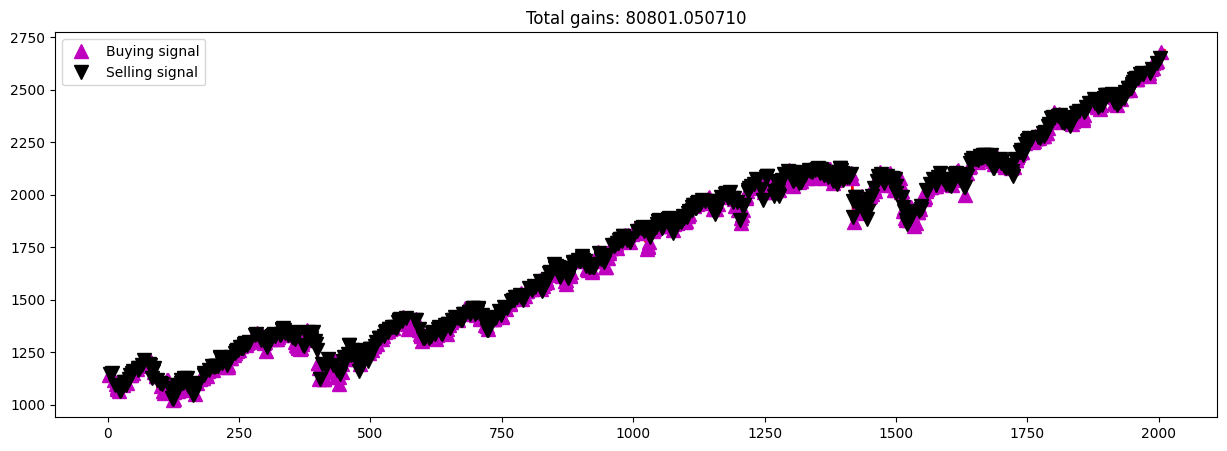

Running episode 25/100
--------------------------------
Total Profit: $65914.05
--------------------------------


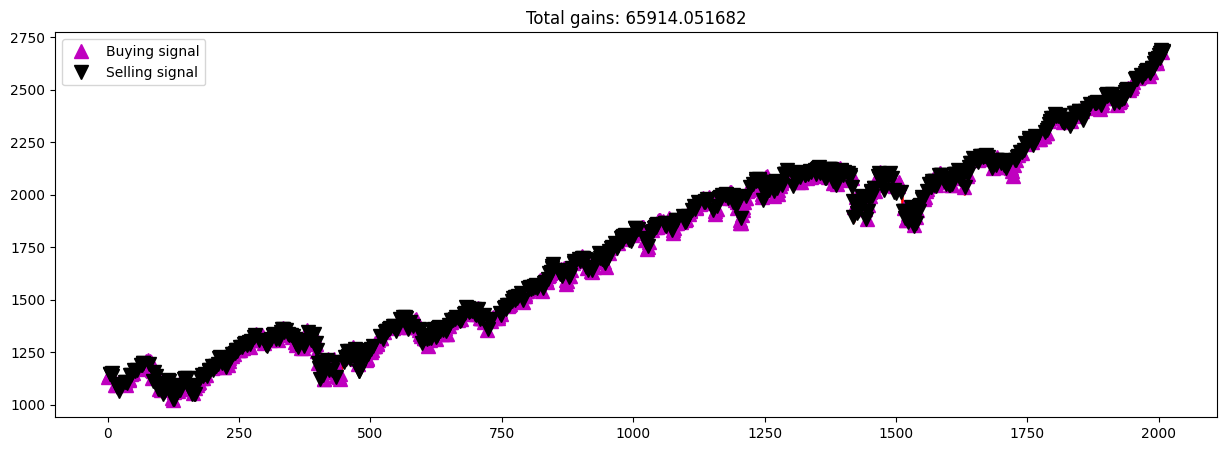

Running episode 26/100
--------------------------------
Total Profit: $34900.59
--------------------------------


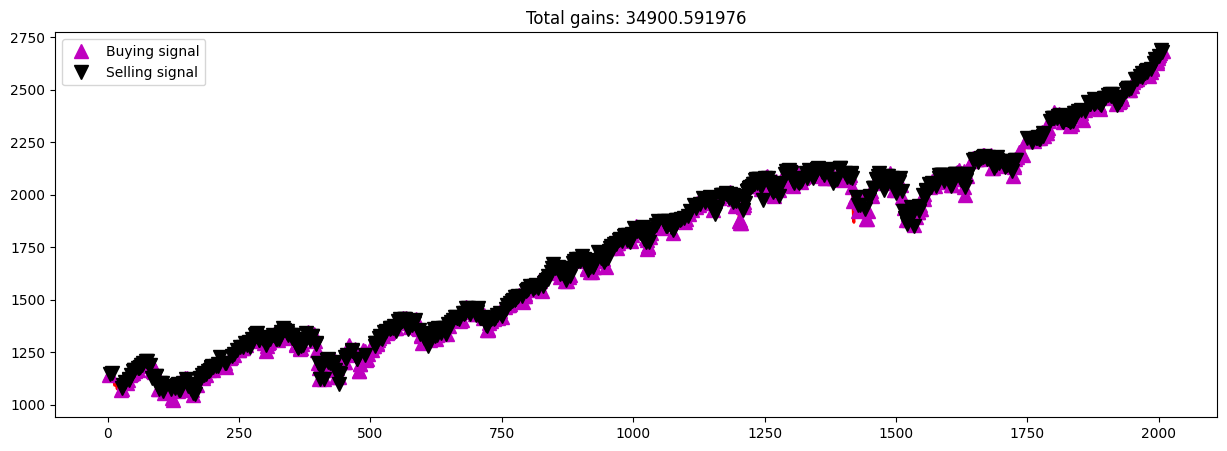

Running episode 27/100
--------------------------------
Total Profit: $63536.68
--------------------------------


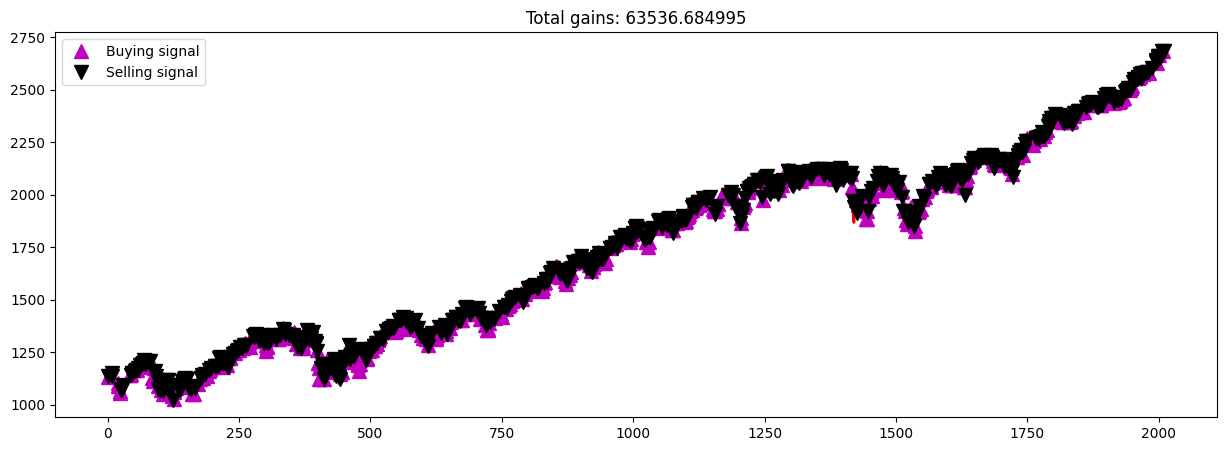

Running episode 28/100
--------------------------------
Total Profit: $30924.97
--------------------------------


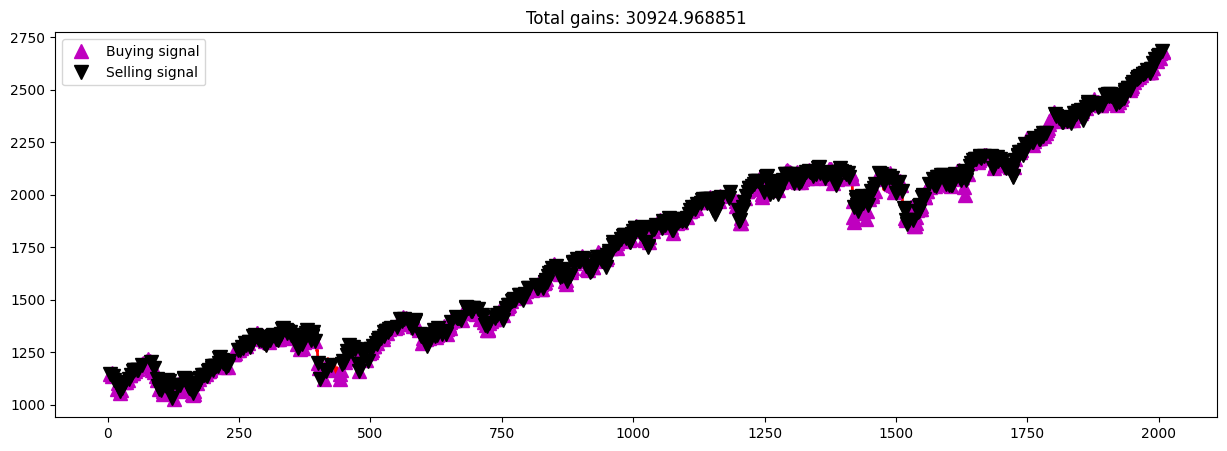

Running episode 29/100
--------------------------------
Total Profit: $27221.50
--------------------------------


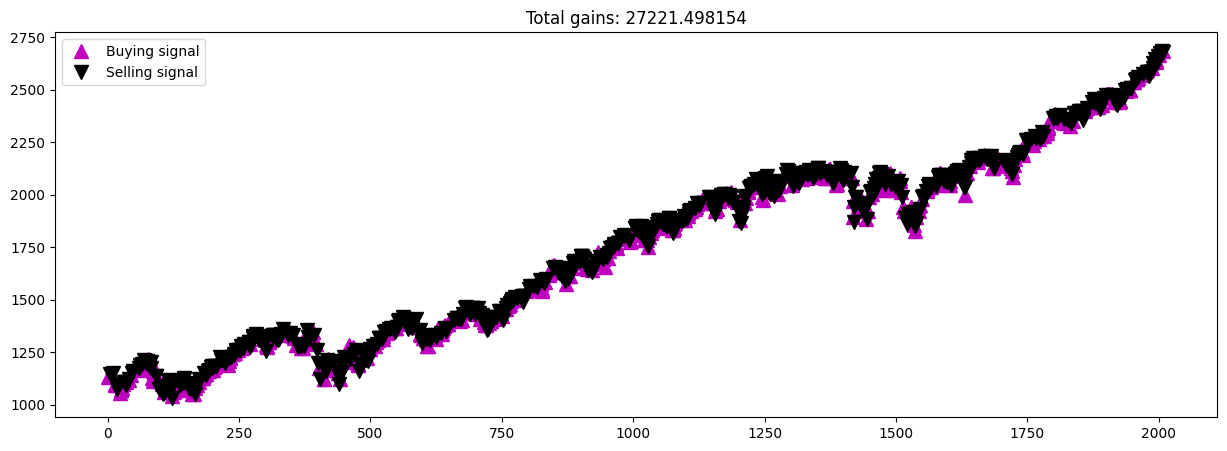

Running episode 30/100
--------------------------------
Total Profit: $6604.60
--------------------------------


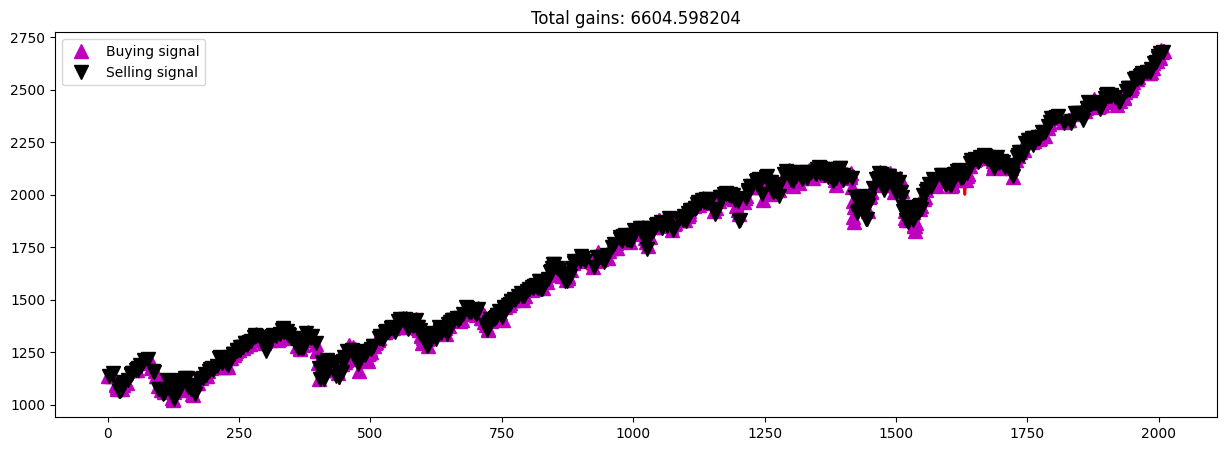

Running episode 31/100
--------------------------------
Total Profit: $17617.73
--------------------------------


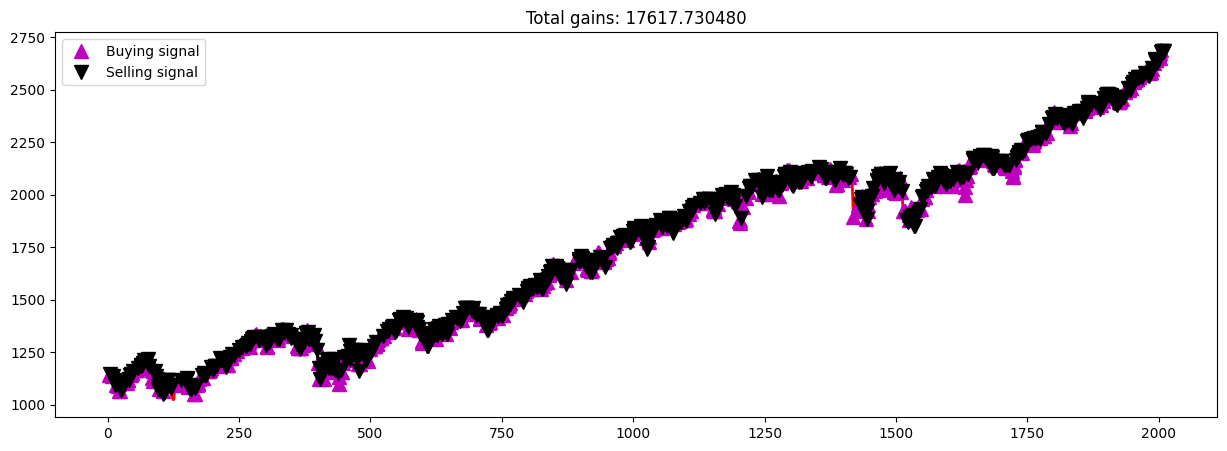

Running episode 32/100
--------------------------------
Total Profit: $63017.07
--------------------------------


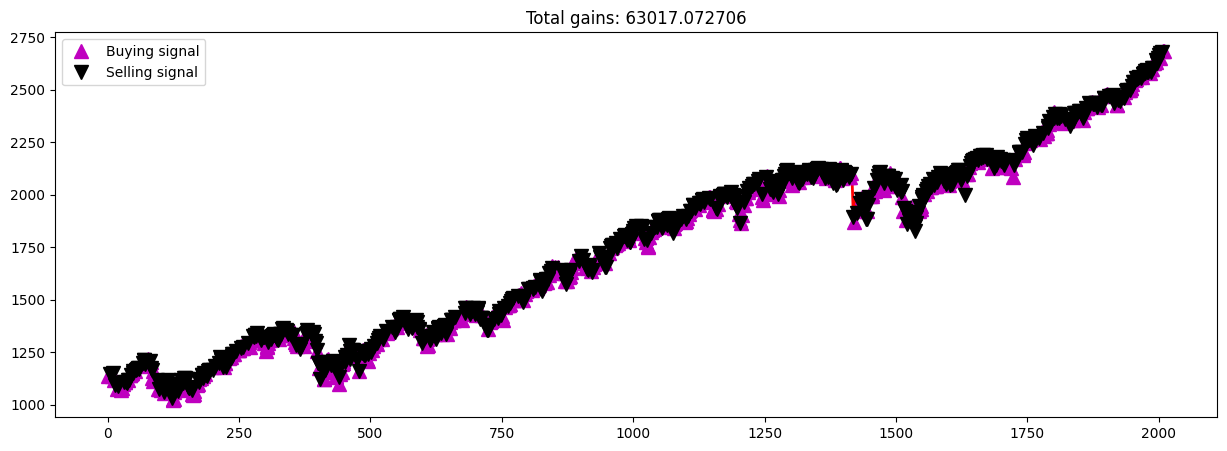

Running episode 33/100
--------------------------------
Total Profit: $16069.07
--------------------------------


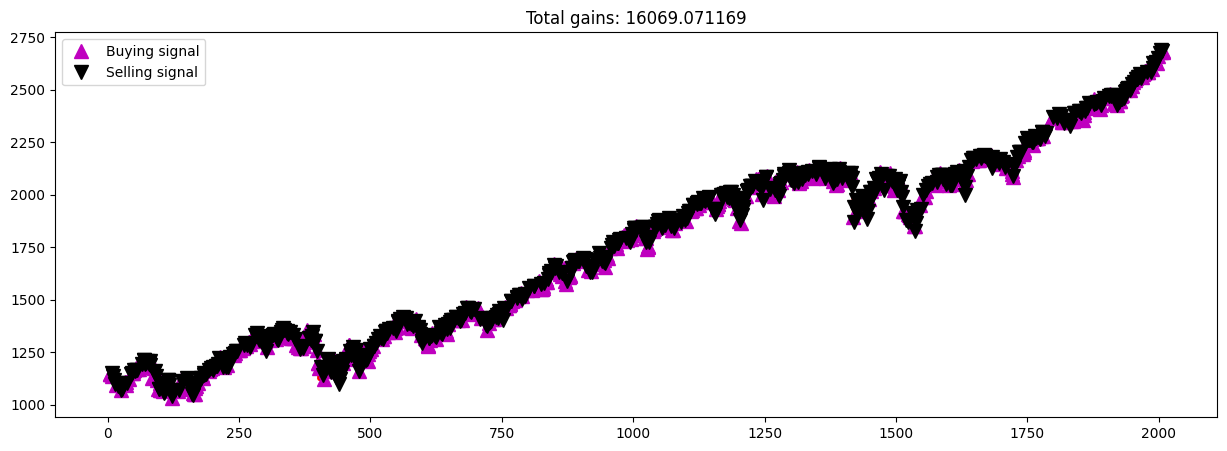

Running episode 34/100
--------------------------------
Total Profit: $12943.12
--------------------------------


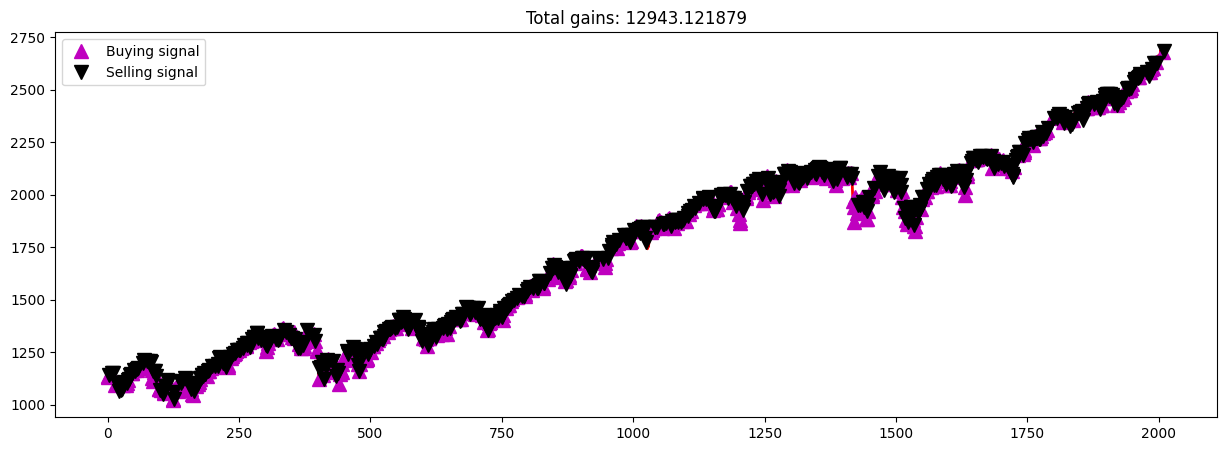

Running episode 35/100
--------------------------------
Total Profit: $37784.95
--------------------------------


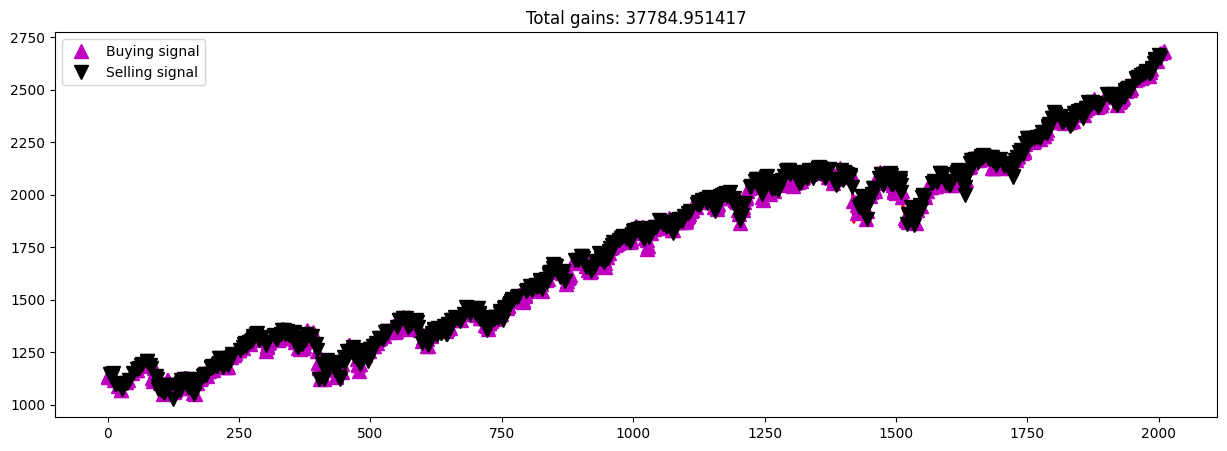

Running episode 36/100
--------------------------------
Total Profit: $27936.52
--------------------------------


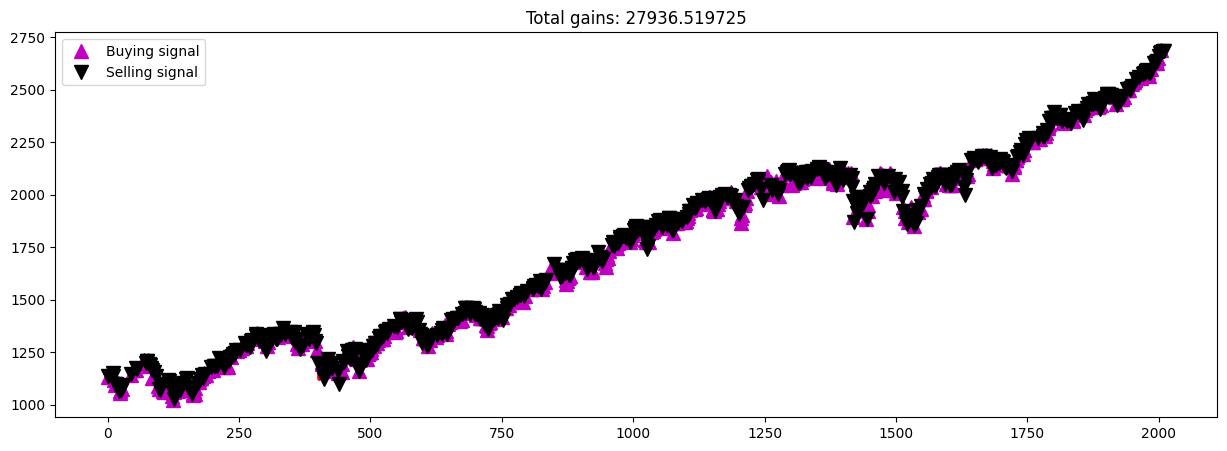

Running episode 37/100
--------------------------------
Total Profit: $8052.21
--------------------------------


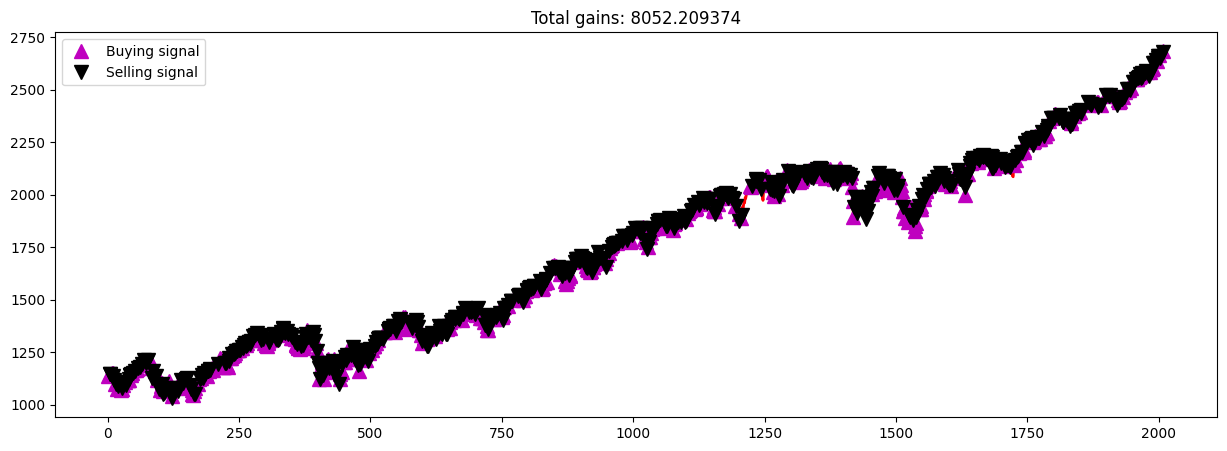

Running episode 38/100
--------------------------------
Total Profit: $15989.81
--------------------------------


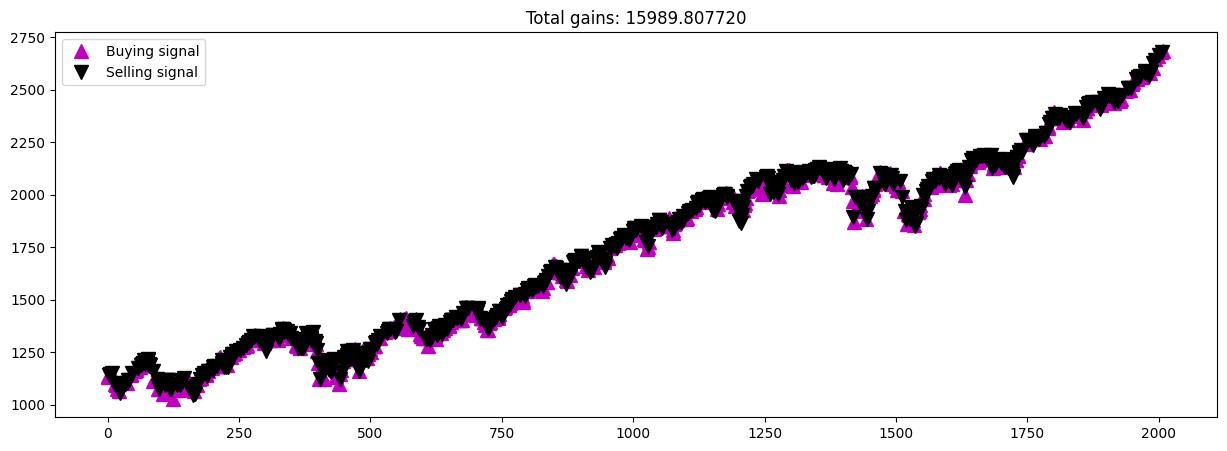

Running episode 39/100
--------------------------------
Total Profit: $30877.85
--------------------------------


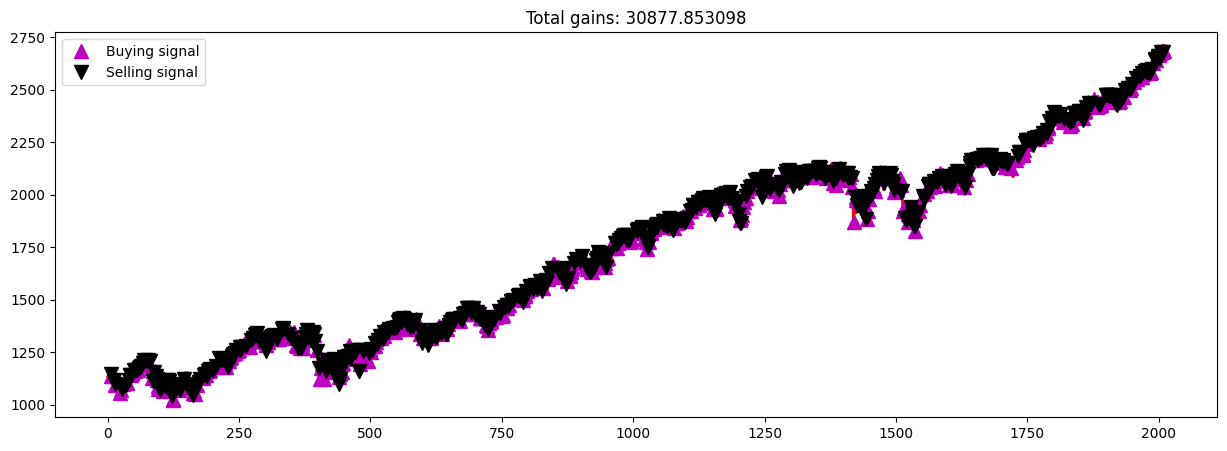

Running episode 40/100
--------------------------------
Total Profit: $28615.15
--------------------------------


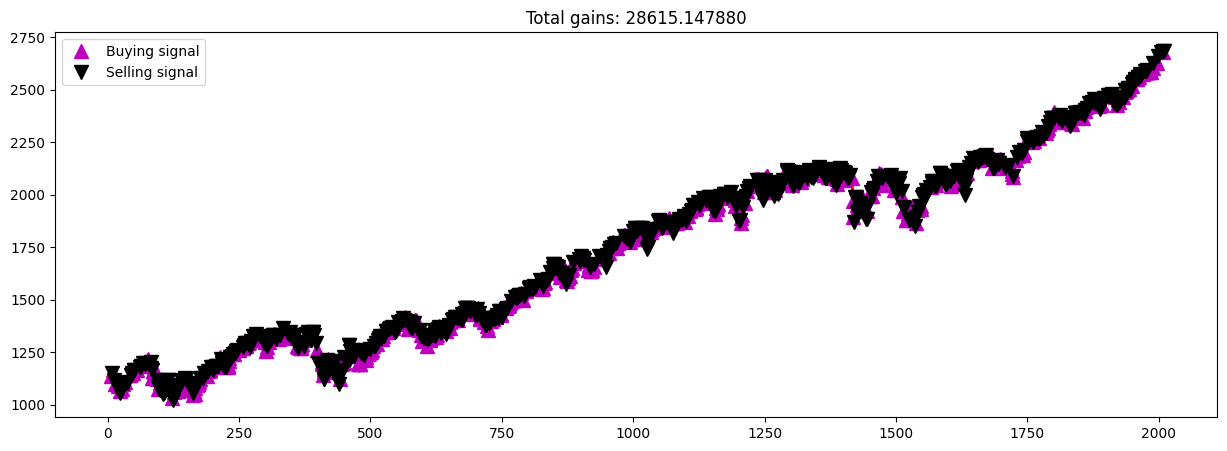

Running episode 41/100
--------------------------------
Total Profit: $32729.93
--------------------------------


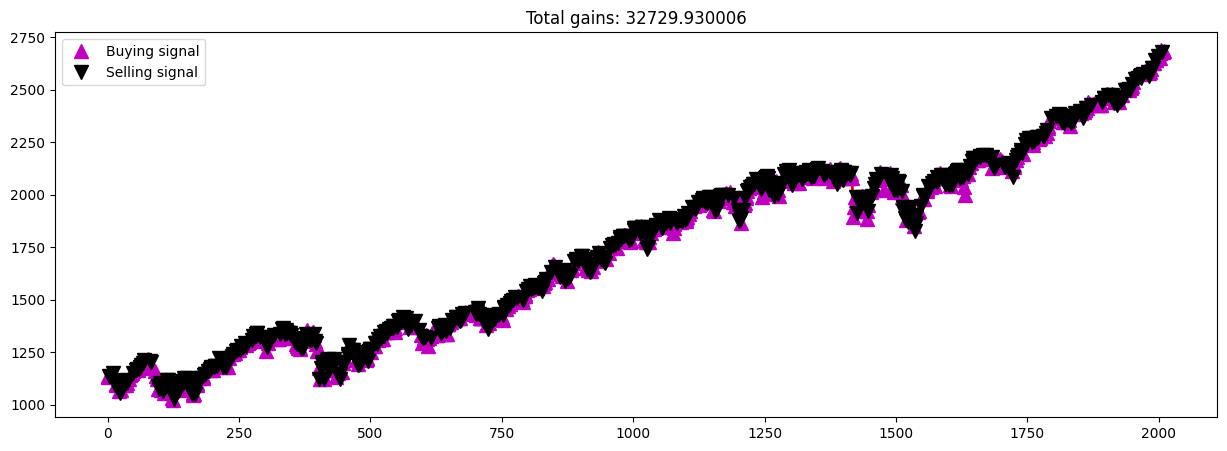

Running episode 42/100
--------------------------------
Total Profit: $17737.75
--------------------------------


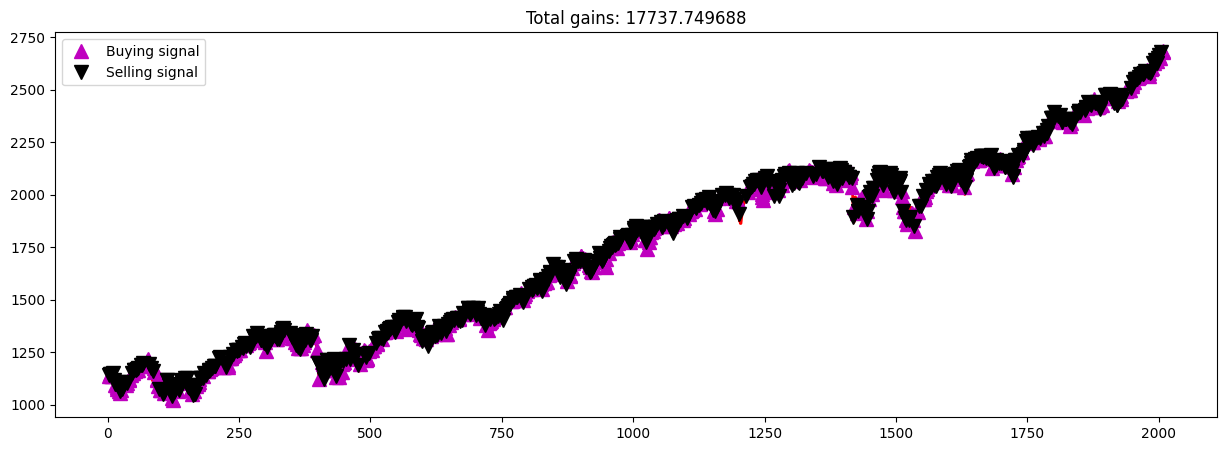

Running episode 43/100
--------------------------------
Total Profit: $27512.37
--------------------------------


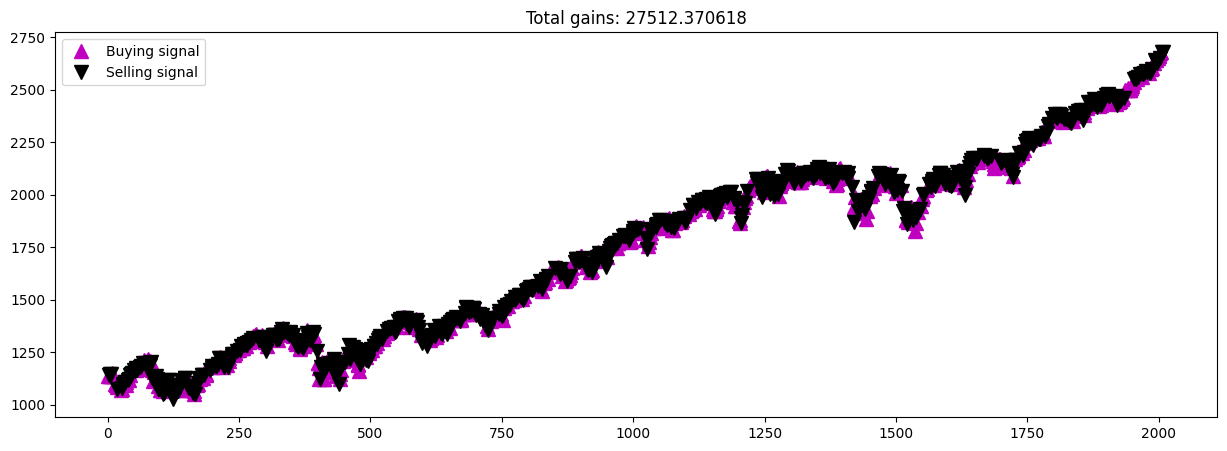

Running episode 44/100
--------------------------------
Total Profit: $44729.36
--------------------------------


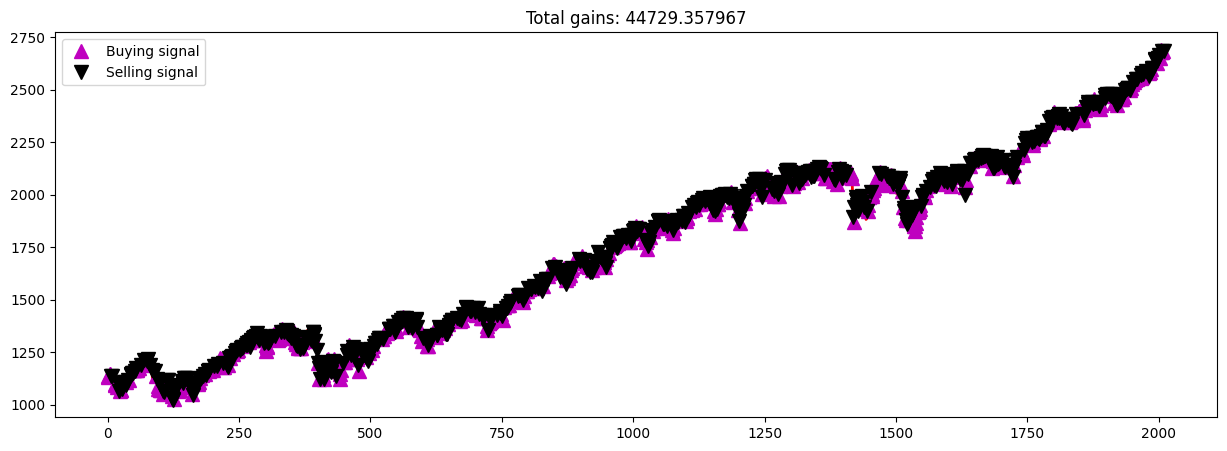

Running episode 45/100
--------------------------------
Total Profit: $30728.90
--------------------------------


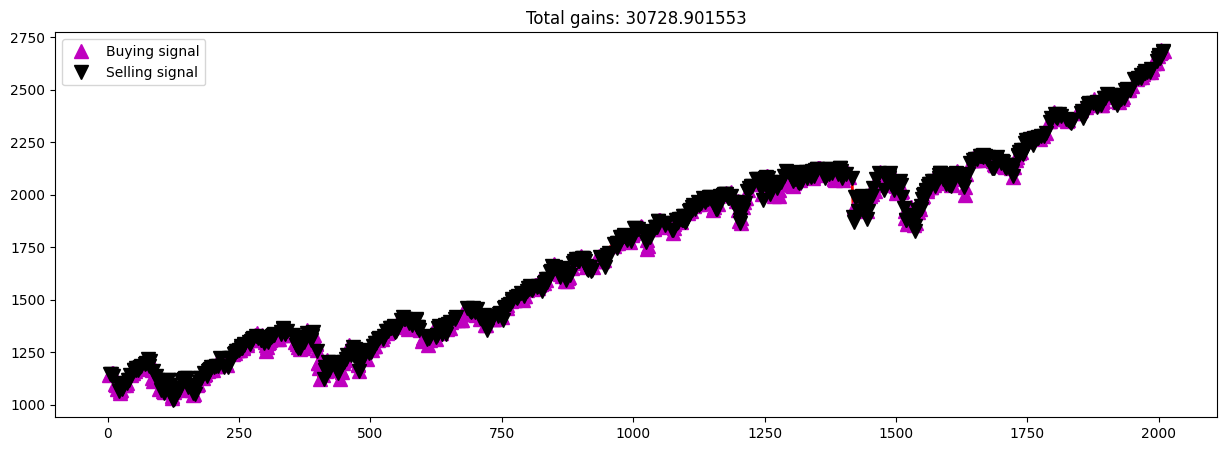

Running episode 46/100
--------------------------------
Total Profit: $15114.67
--------------------------------


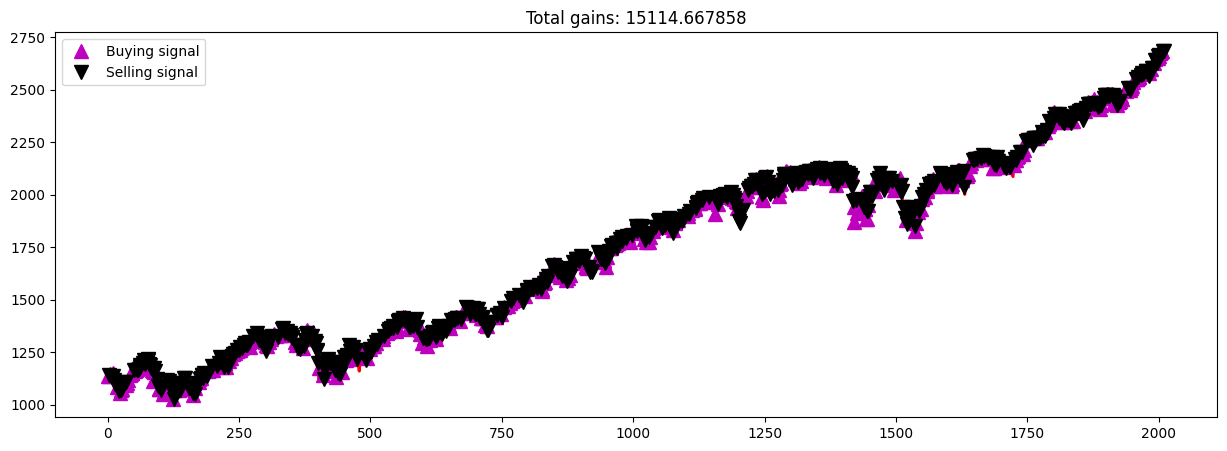

Running episode 47/100
--------------------------------
Total Profit: $49332.61
--------------------------------


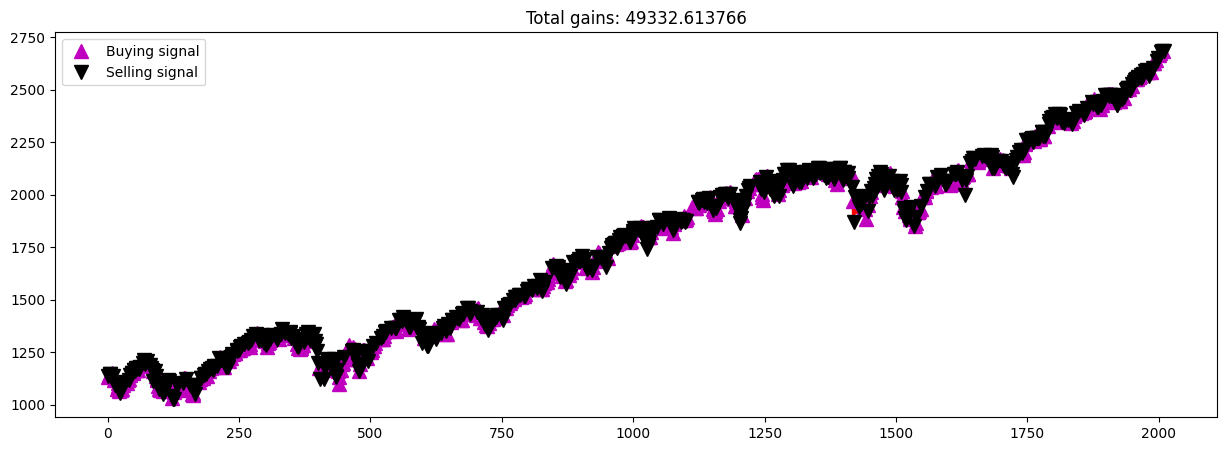

Running episode 48/100
--------------------------------
Total Profit: $42166.14
--------------------------------


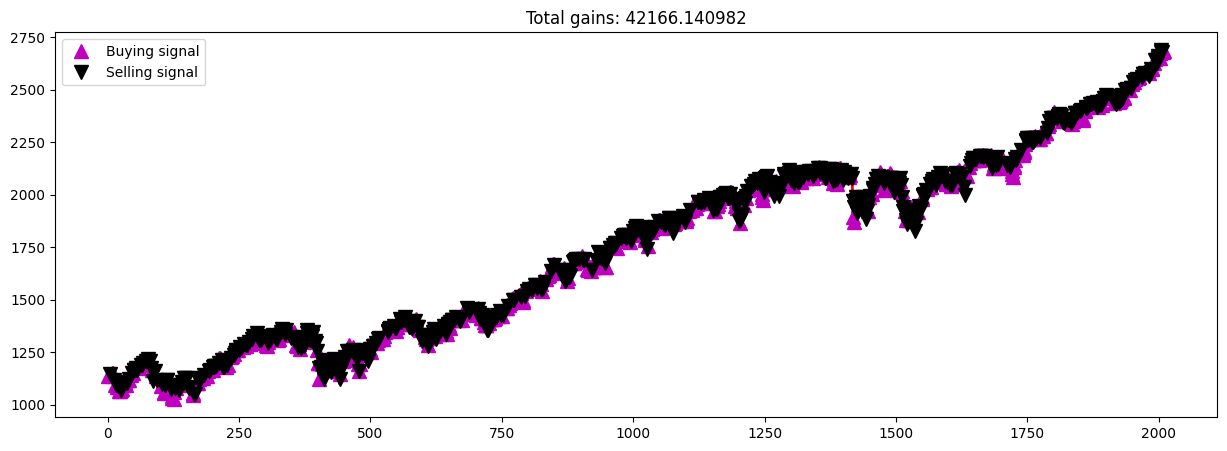

Running episode 49/100
--------------------------------
Total Profit: $42237.10
--------------------------------


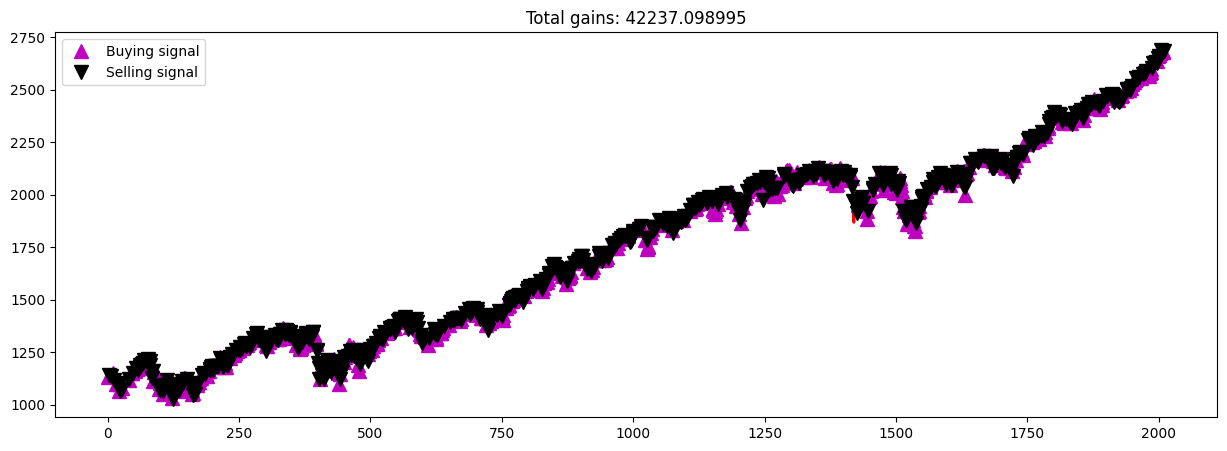

Running episode 50/100
--------------------------------
Total Profit: $18821.29
--------------------------------


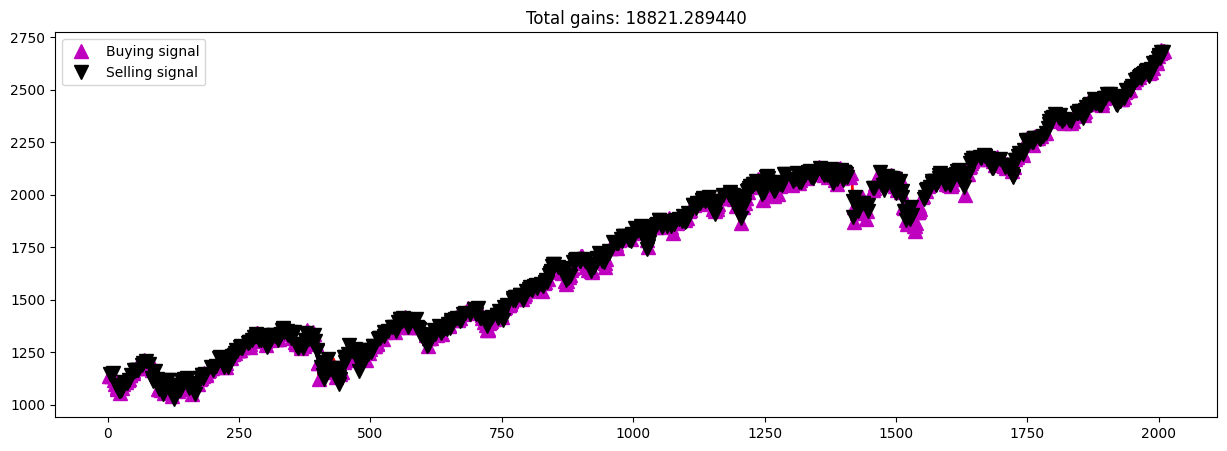

Running episode 51/100
--------------------------------
Total Profit: $27146.31
--------------------------------


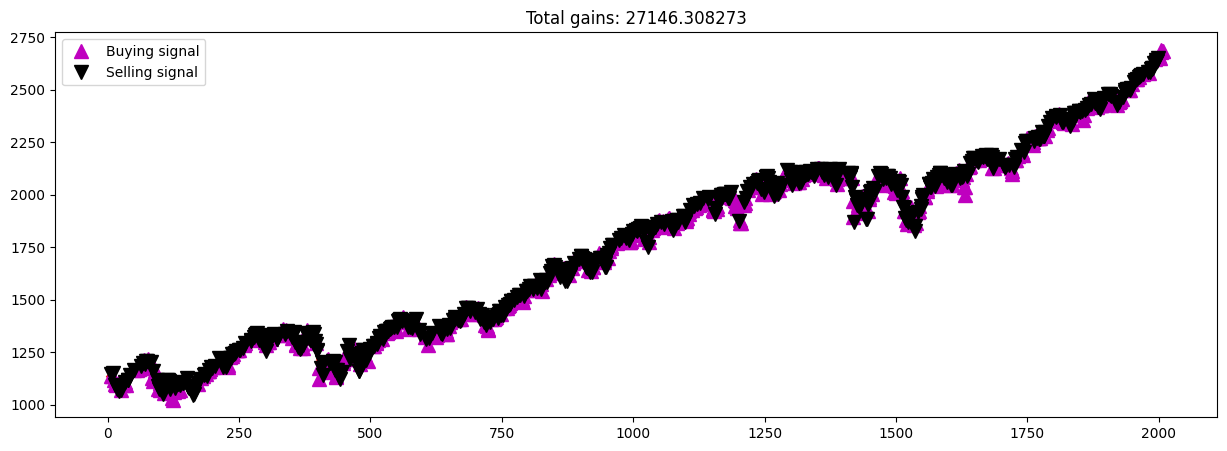

Running episode 52/100
--------------------------------
Total Profit: $49973.61
--------------------------------


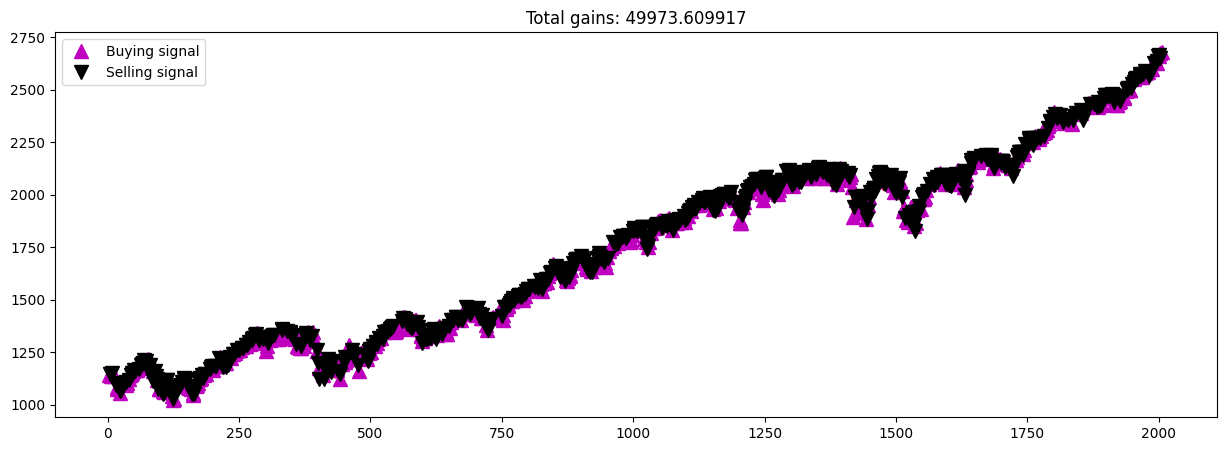

Running episode 53/100
--------------------------------
Total Profit: $26202.53
--------------------------------


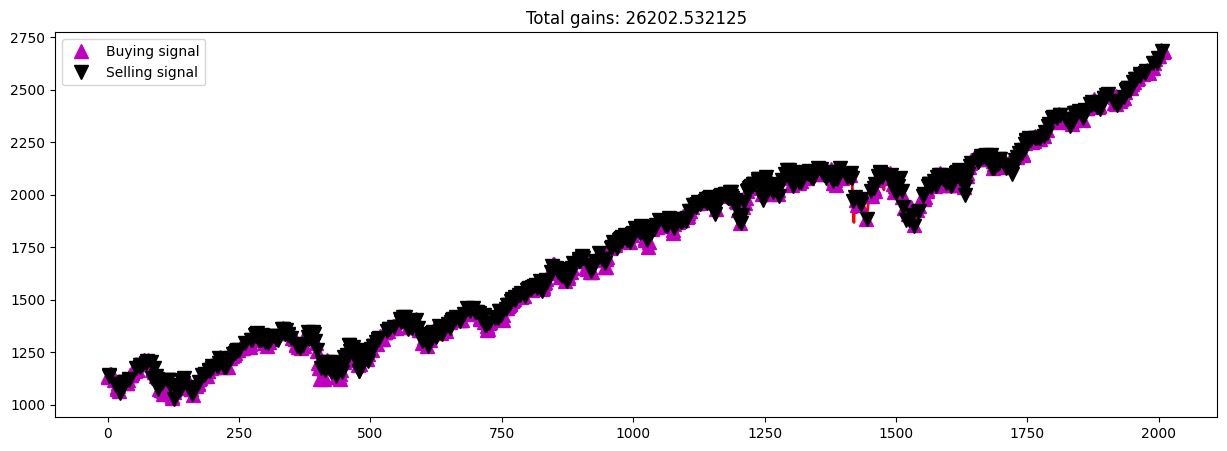

Running episode 54/100
--------------------------------
Total Profit: $36173.31
--------------------------------


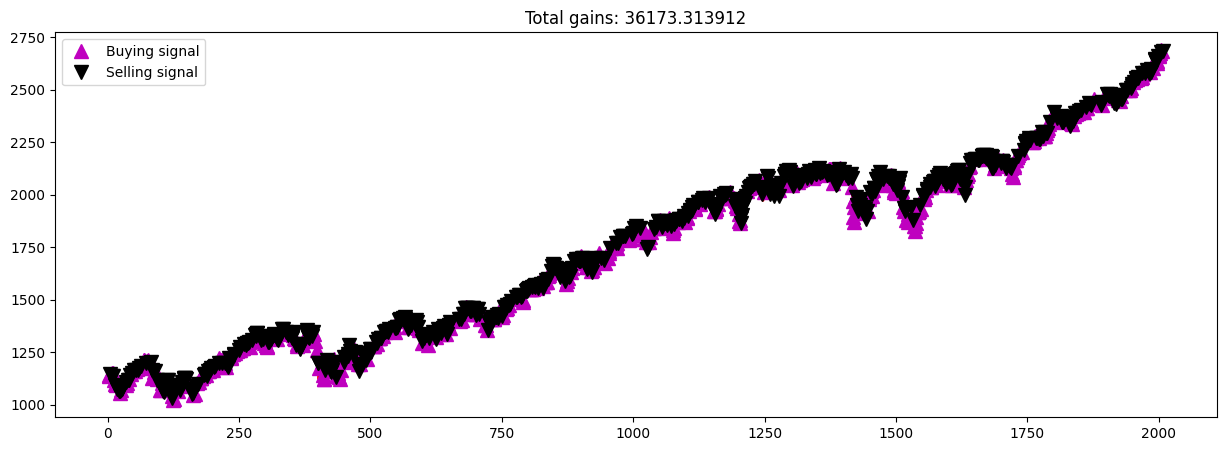

Running episode 55/100
--------------------------------
Total Profit: $19131.77
--------------------------------


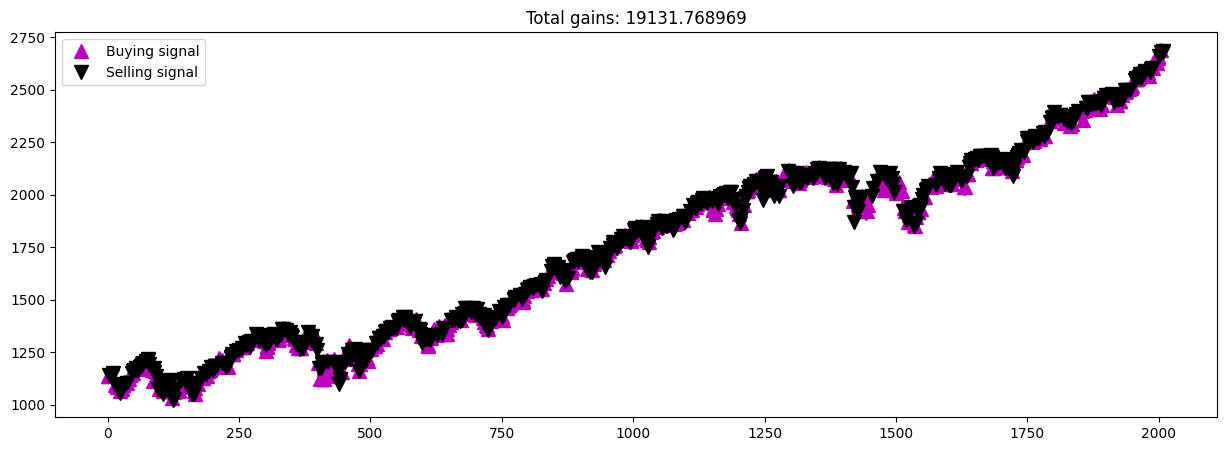

Running episode 56/100
--------------------------------
Total Profit: $24430.51
--------------------------------


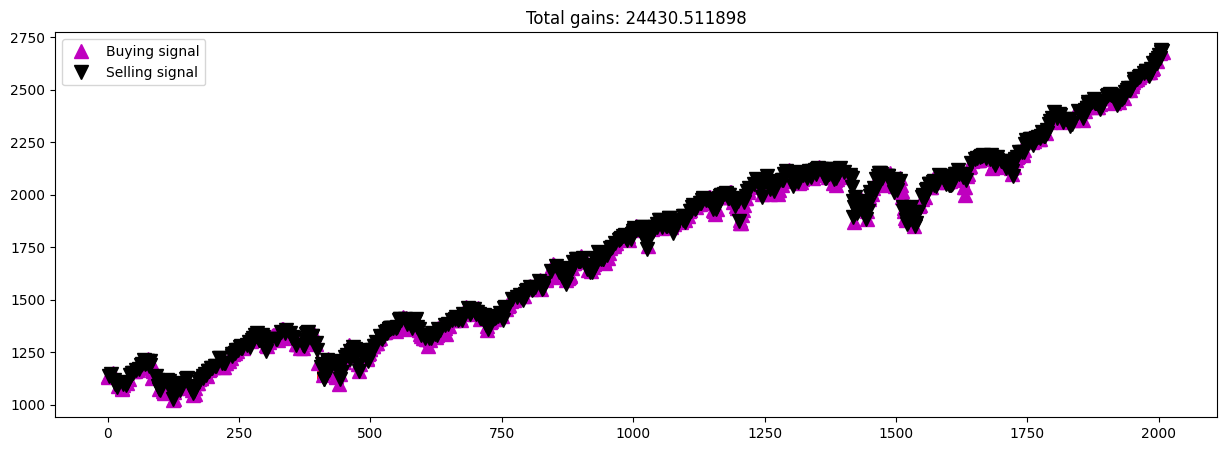

Running episode 57/100
--------------------------------
Total Profit: $25828.86
--------------------------------


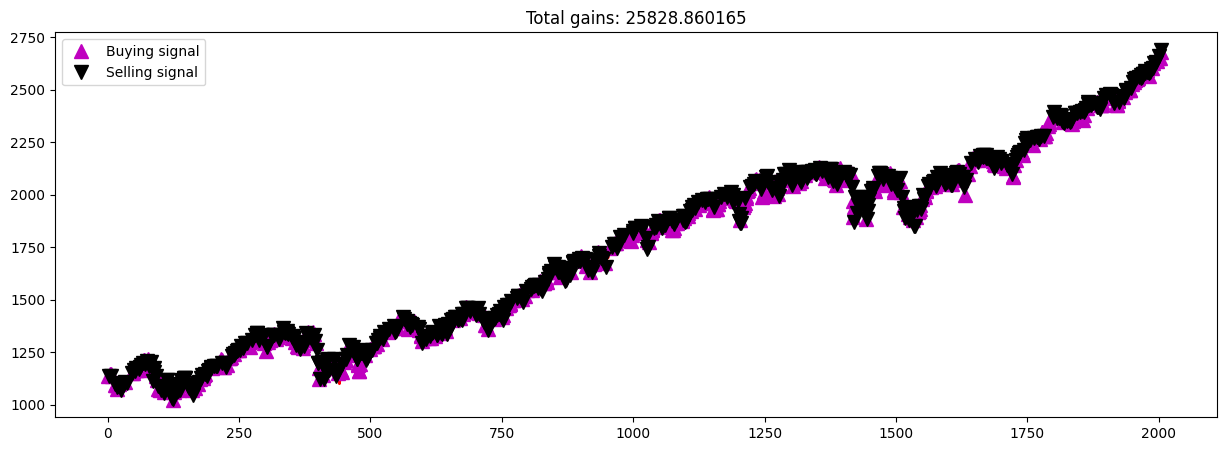

Running episode 58/100
--------------------------------
Total Profit: $42799.94
--------------------------------


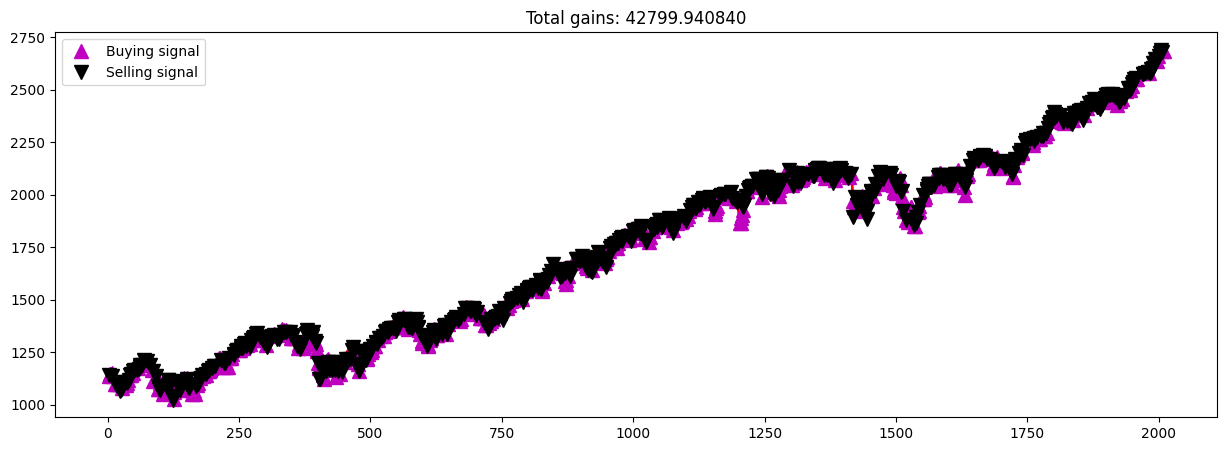

Running episode 59/100
--------------------------------
Total Profit: $43429.26
--------------------------------


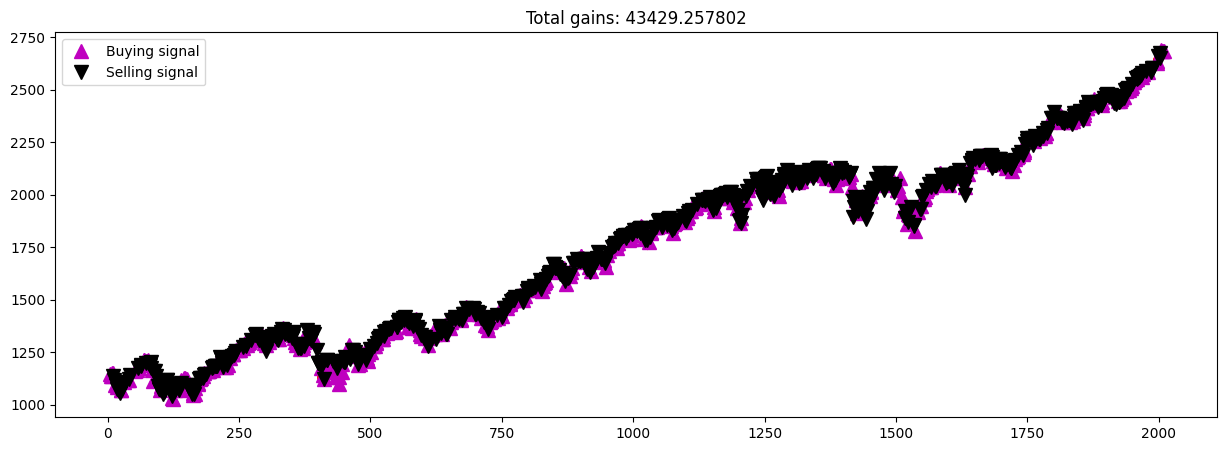

Running episode 60/100
--------------------------------
Total Profit: $21093.01
--------------------------------


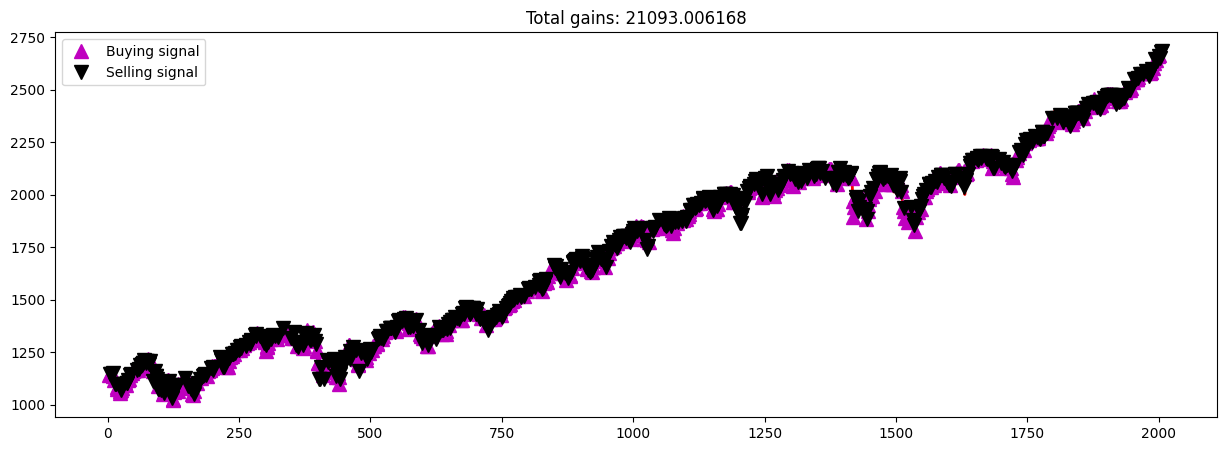

Running episode 61/100
--------------------------------
Total Profit: $49842.18
--------------------------------


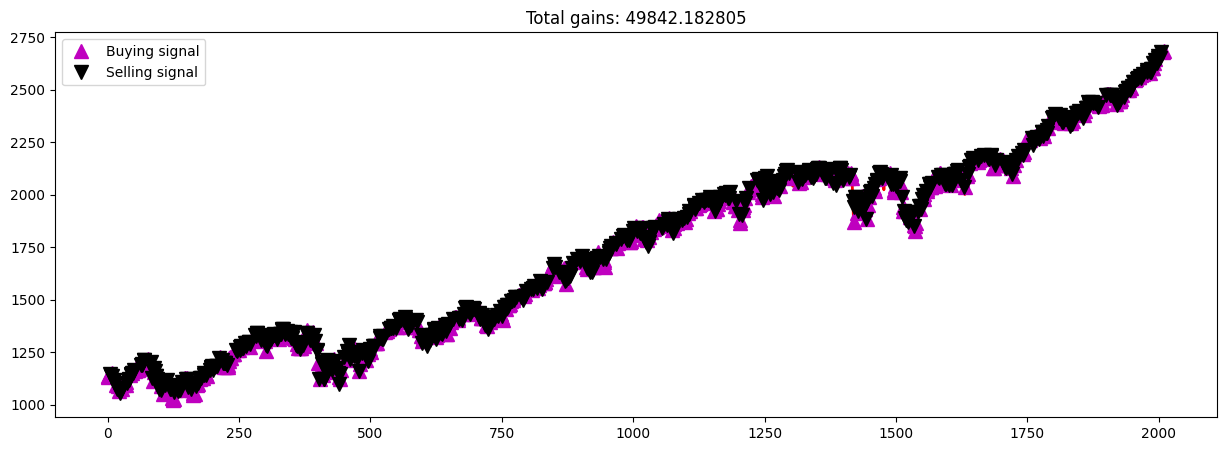

Running episode 62/100
--------------------------------
Total Profit: $10530.50
--------------------------------


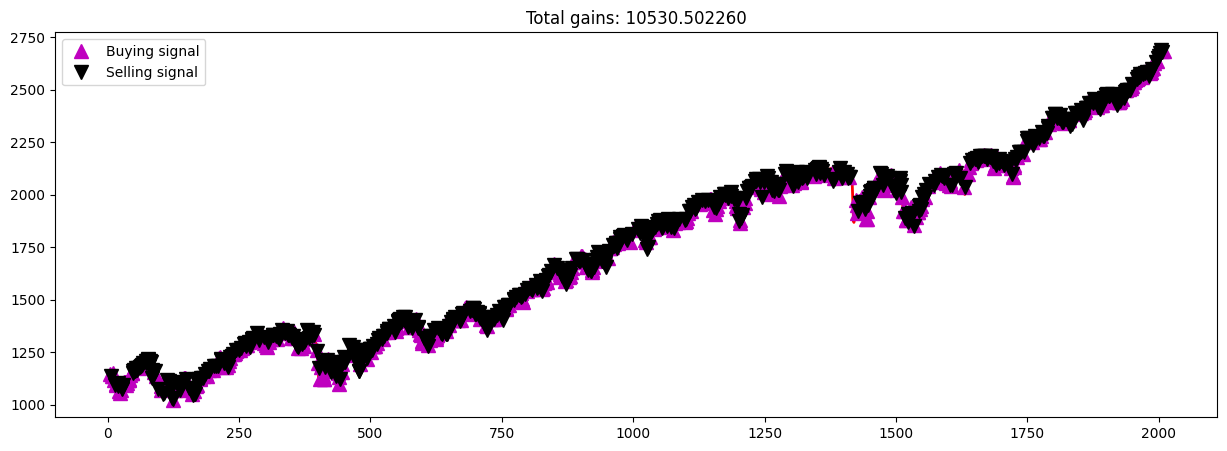

Running episode 63/100
--------------------------------
Total Profit: $25460.13
--------------------------------


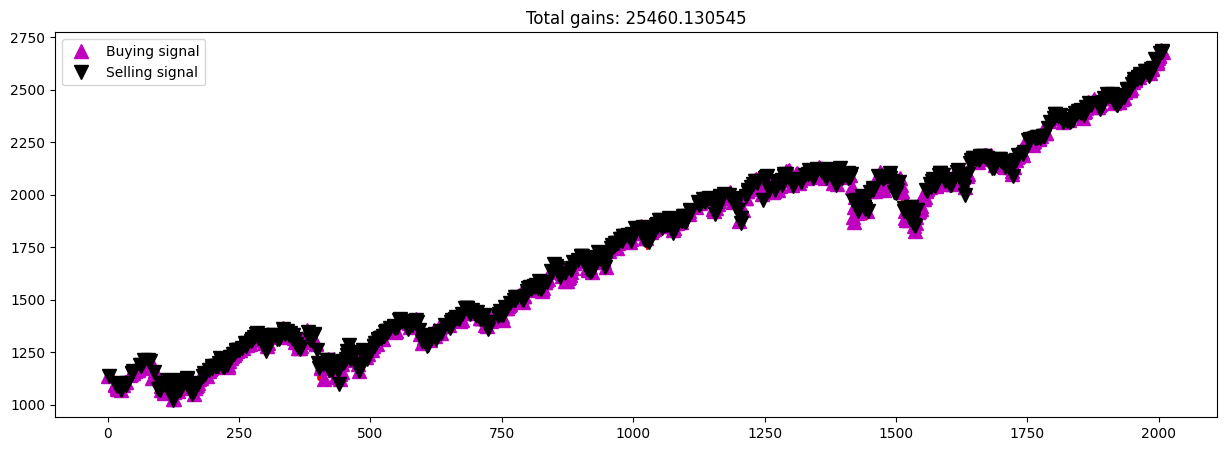

Running episode 64/100
--------------------------------
Total Profit: $19547.94
--------------------------------


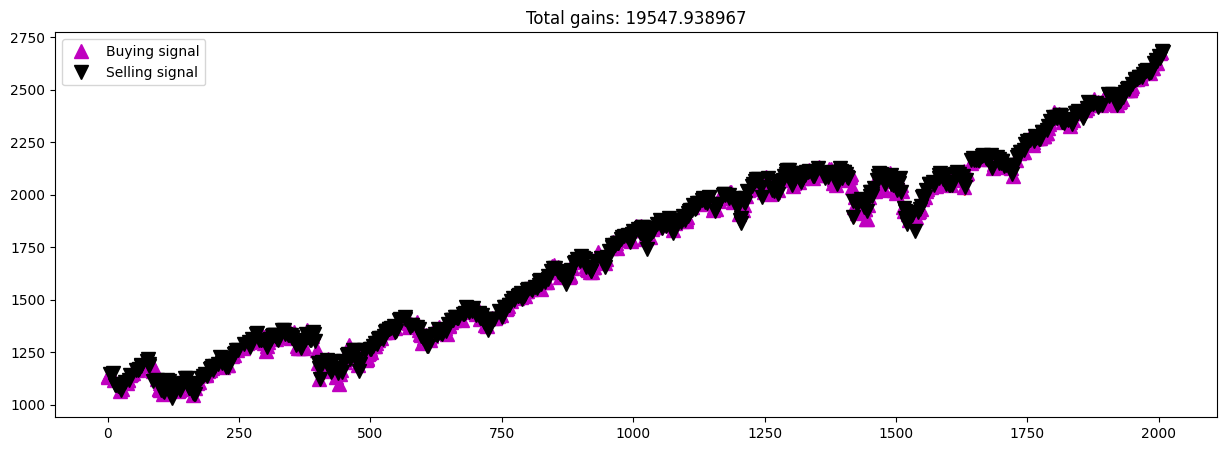

Running episode 65/100
--------------------------------
Total Profit: $25925.91
--------------------------------


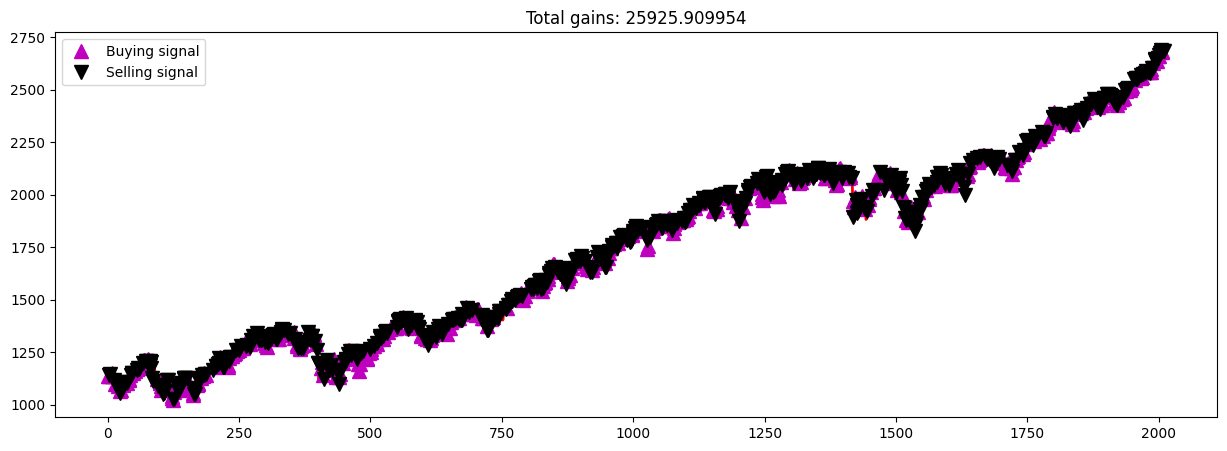

Running episode 66/100
--------------------------------
Total Profit: $21811.37
--------------------------------


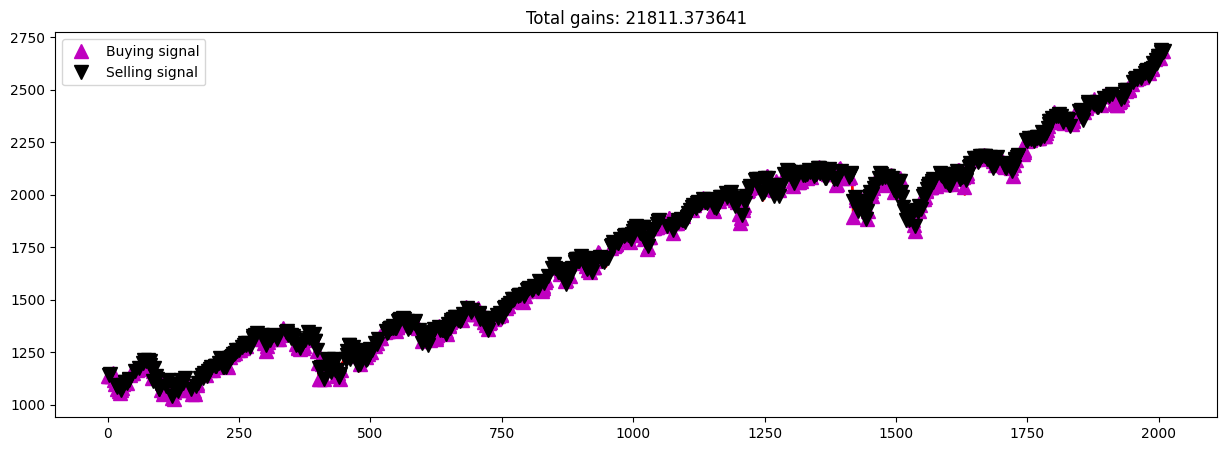

Running episode 67/100
--------------------------------
Total Profit: $12346.98
--------------------------------


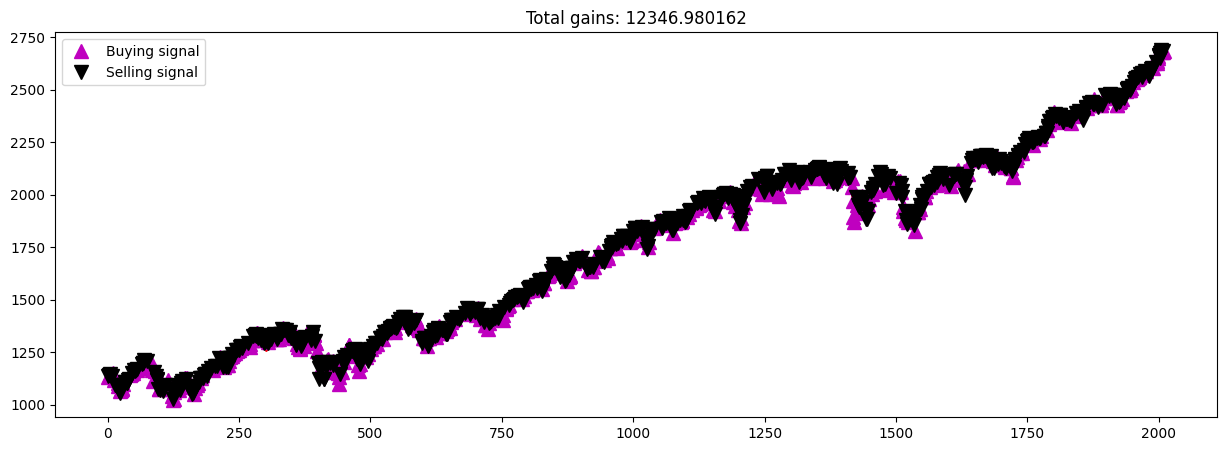

Running episode 68/100
--------------------------------
Total Profit: $24082.76
--------------------------------


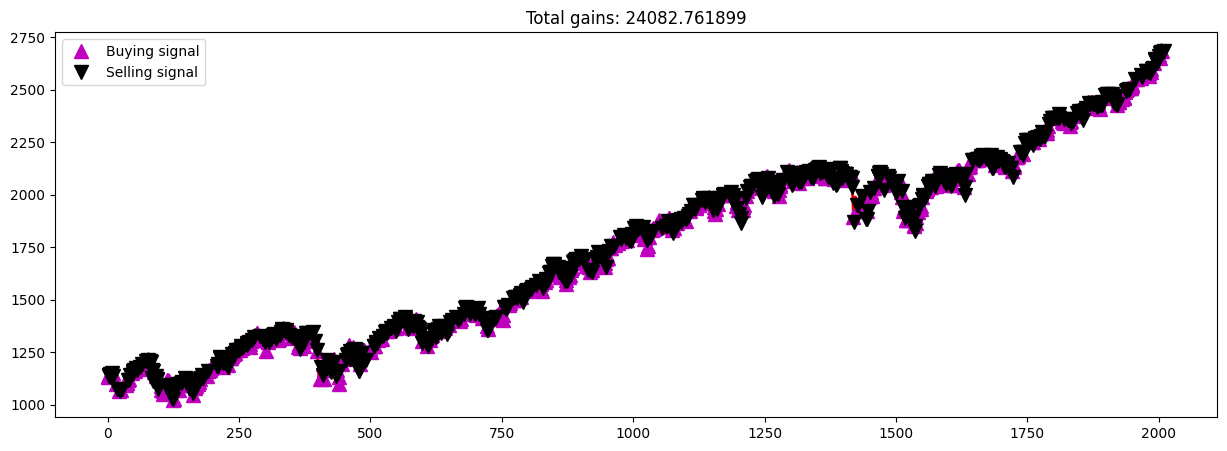

Running episode 69/100
--------------------------------
Total Profit: $18487.74
--------------------------------


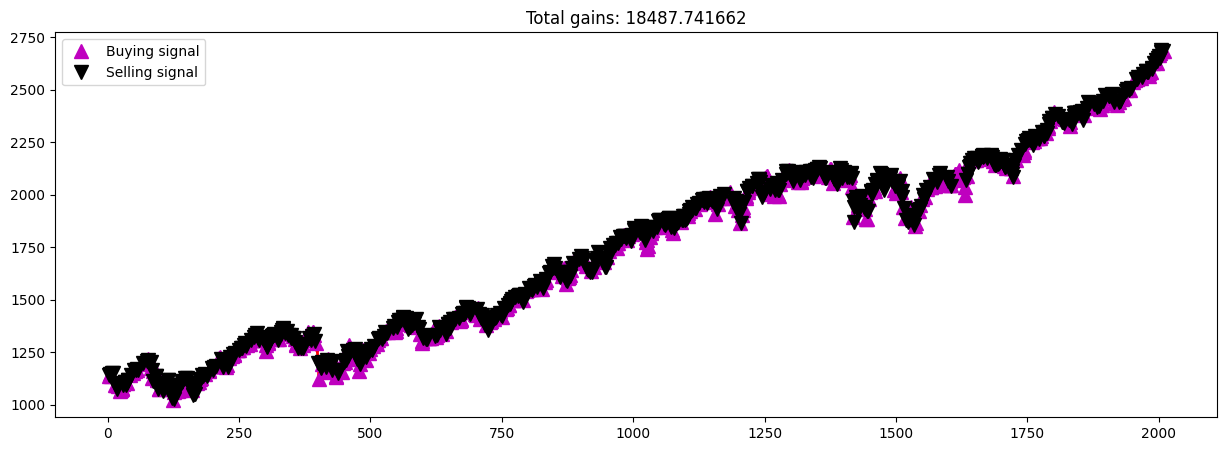

Running episode 70/100
--------------------------------
Total Profit: $53165.07
--------------------------------


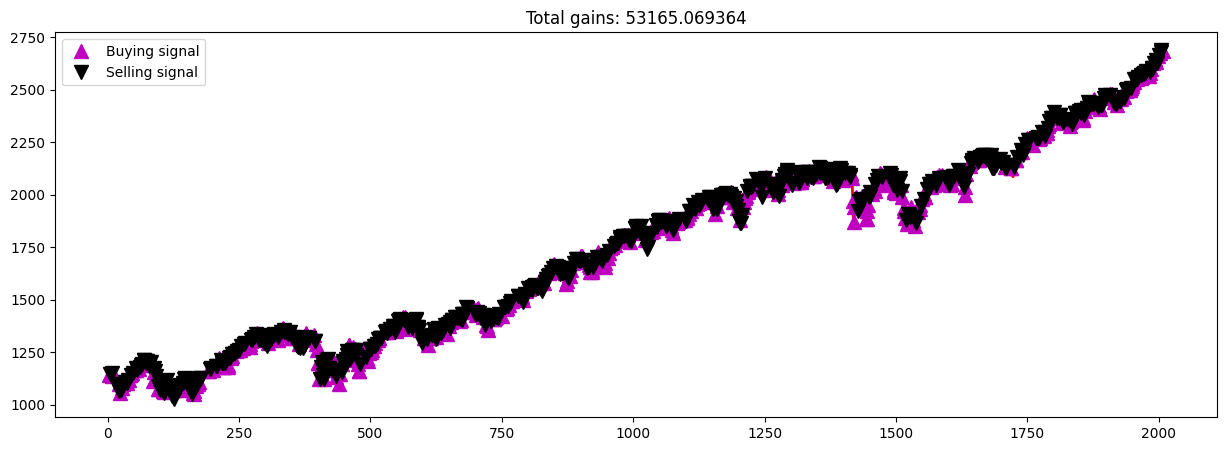

Running episode 71/100
--------------------------------
Total Profit: $21300.28
--------------------------------


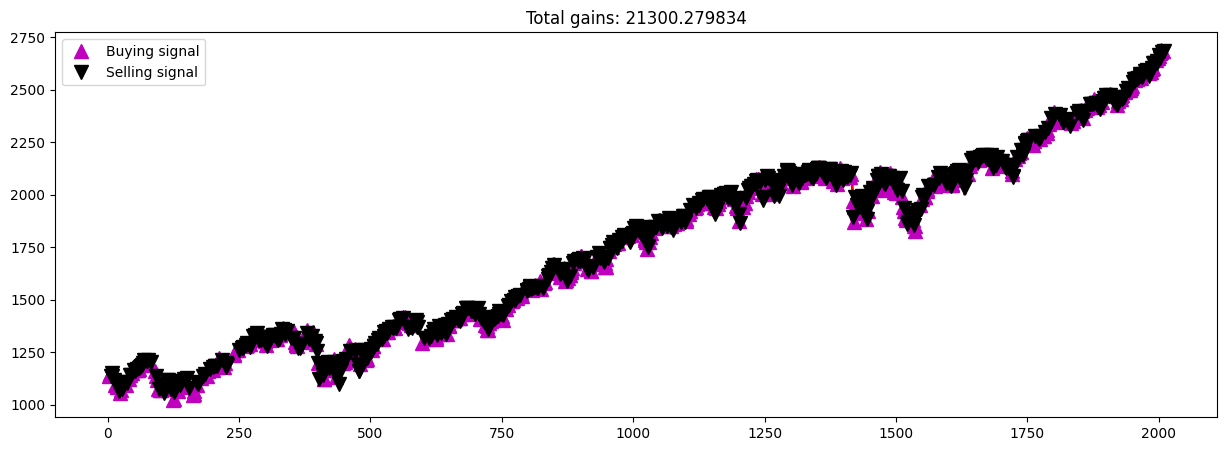

Running episode 72/100
--------------------------------
Total Profit: $22451.44
--------------------------------


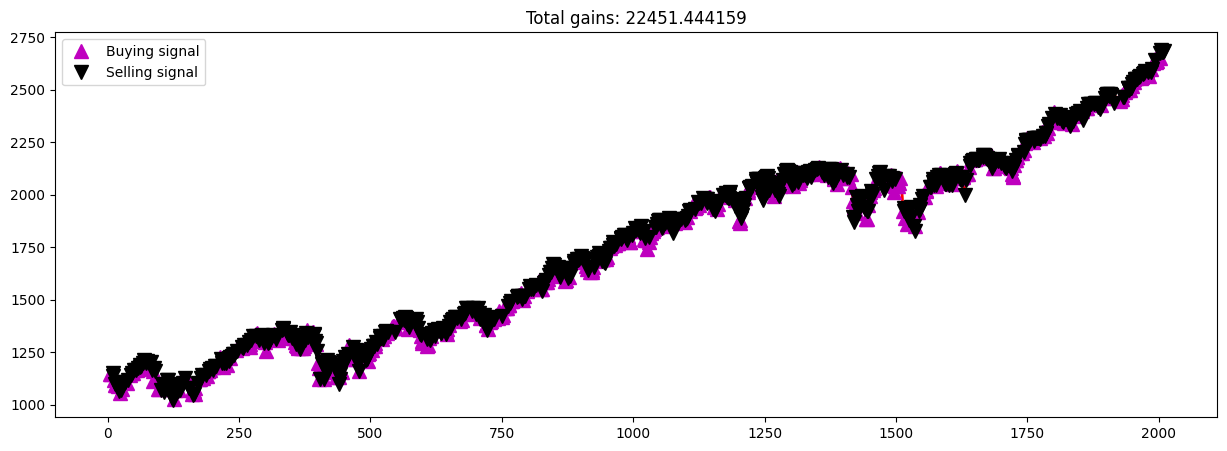

Running episode 73/100
--------------------------------
Total Profit: $23567.51
--------------------------------


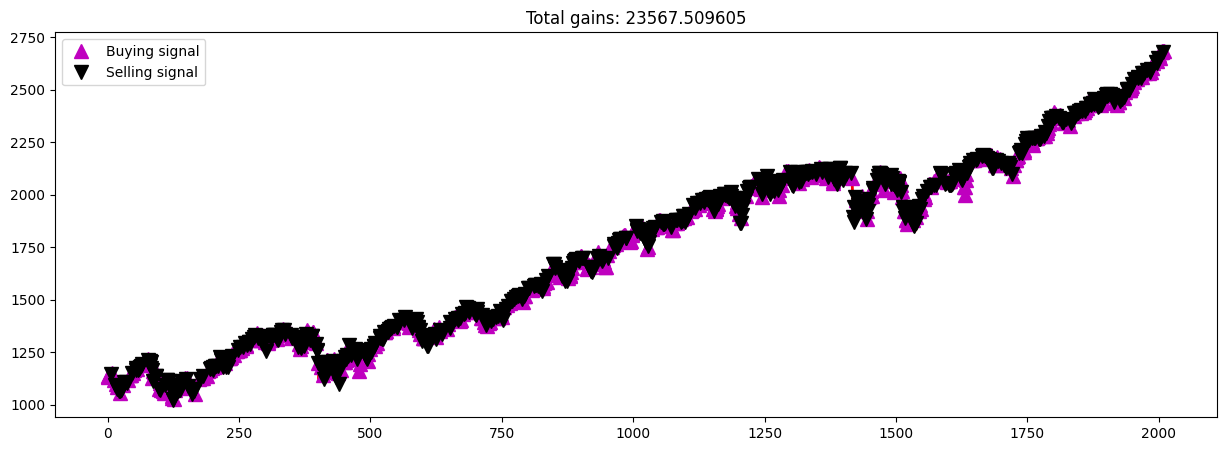

Running episode 74/100
--------------------------------
Total Profit: $14517.11
--------------------------------


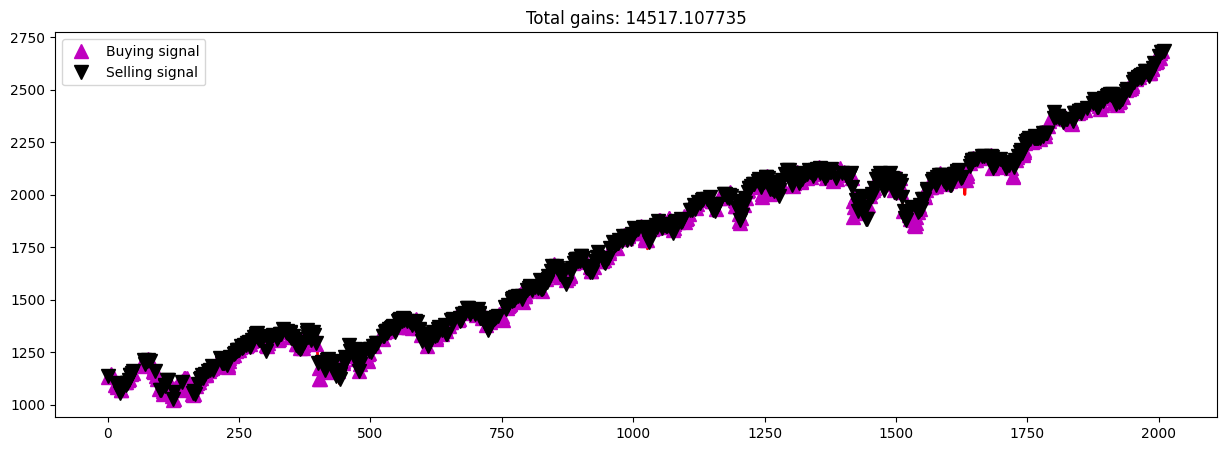

Running episode 75/100
--------------------------------
Total Profit: $35008.94
--------------------------------


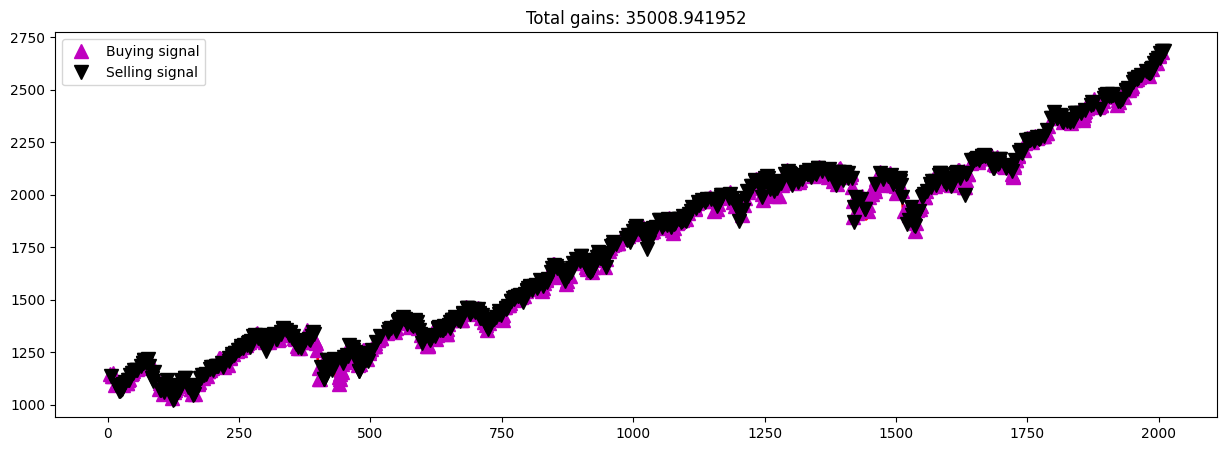

Running episode 76/100
--------------------------------
Total Profit: $26968.85
--------------------------------


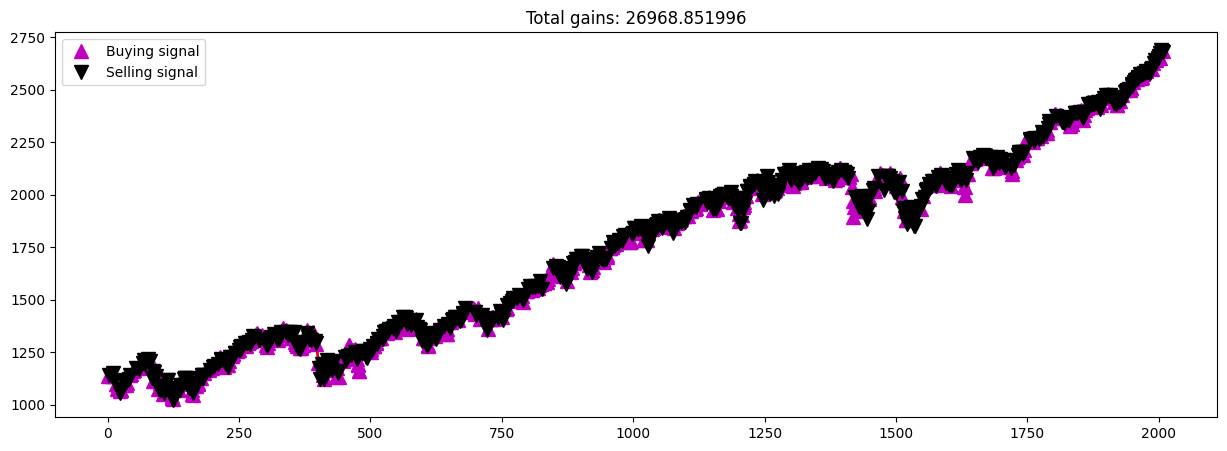

Running episode 77/100
--------------------------------
Total Profit: $22521.33
--------------------------------


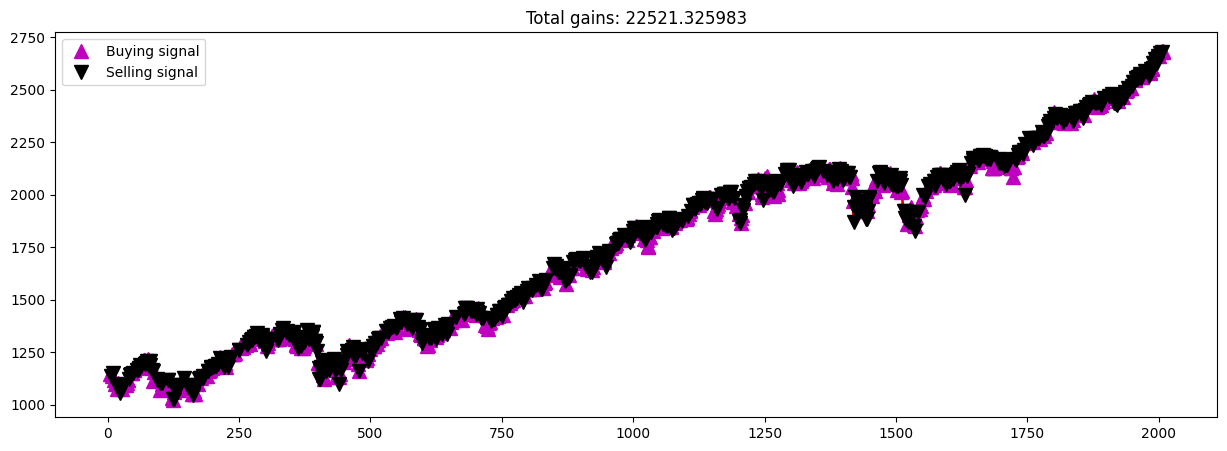

Running episode 78/100
--------------------------------
Total Profit: $100372.19
--------------------------------


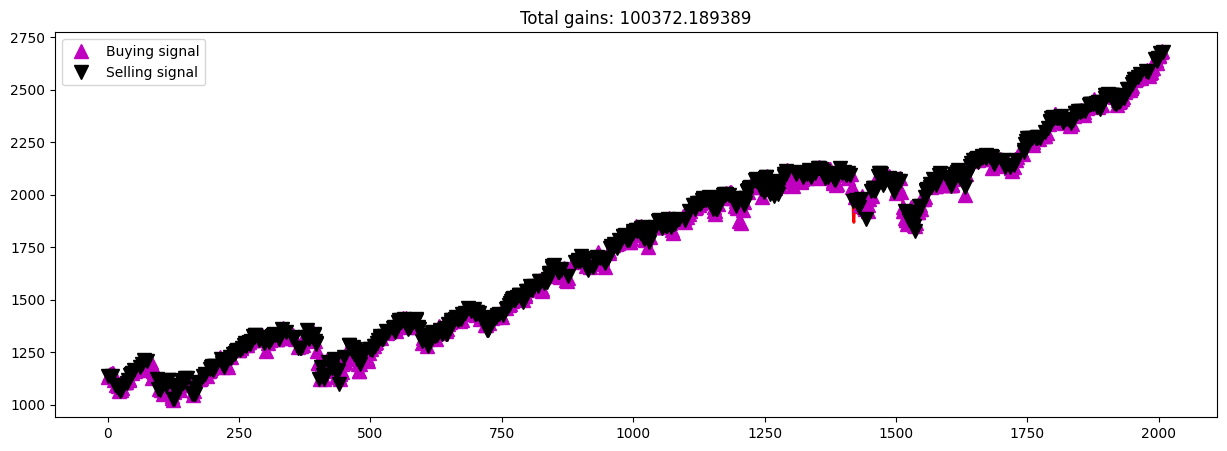

Running episode 79/100
--------------------------------
Total Profit: $56317.97
--------------------------------


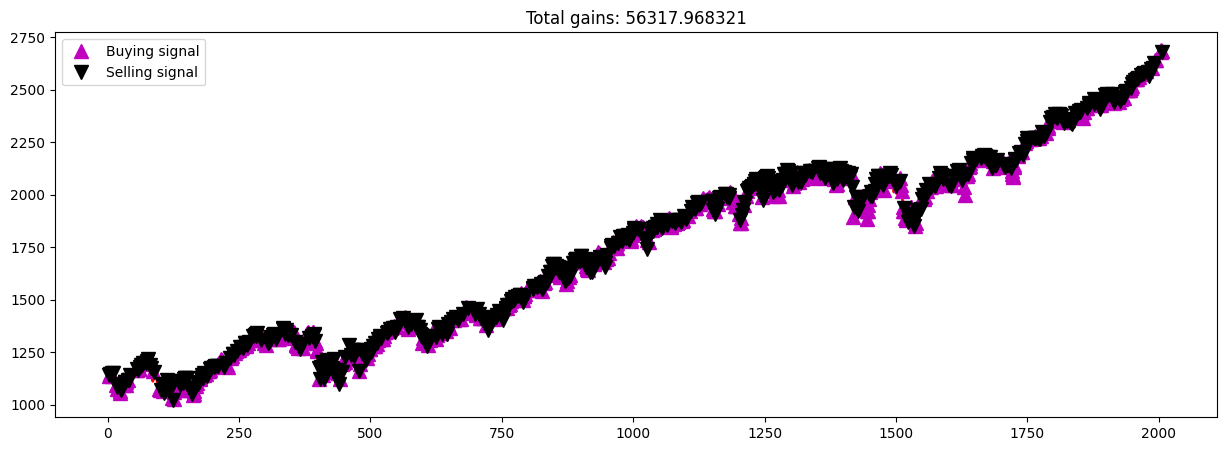

Running episode 80/100
--------------------------------
Total Profit: $37668.21
--------------------------------


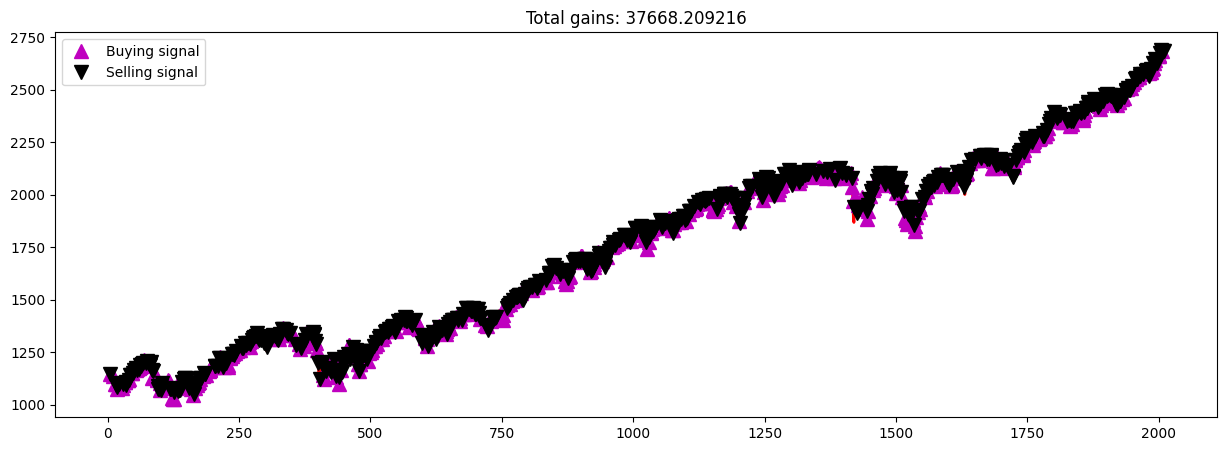

Running episode 81/100
--------------------------------
Total Profit: $16200.22
--------------------------------


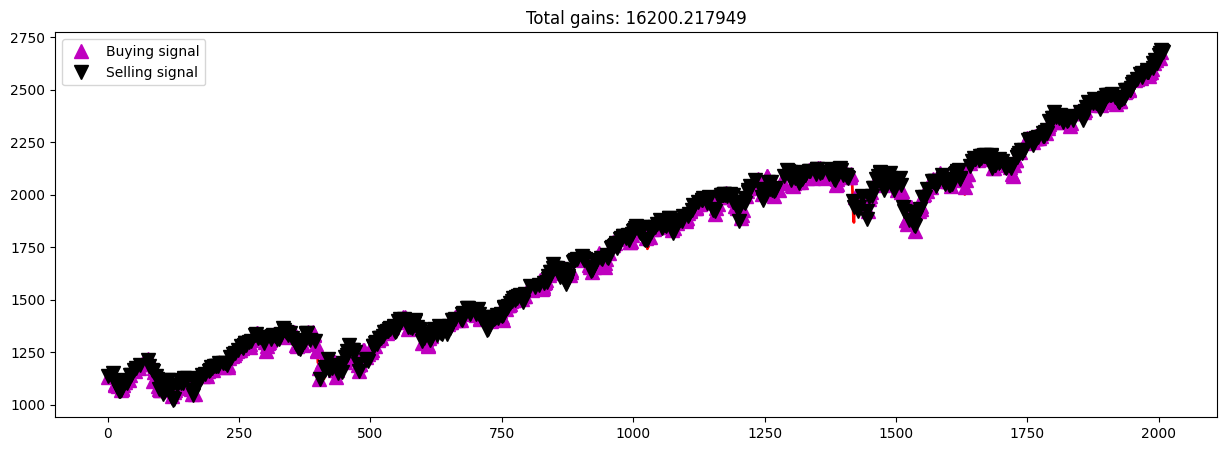

Running episode 82/100
--------------------------------
Total Profit: $16569.78
--------------------------------


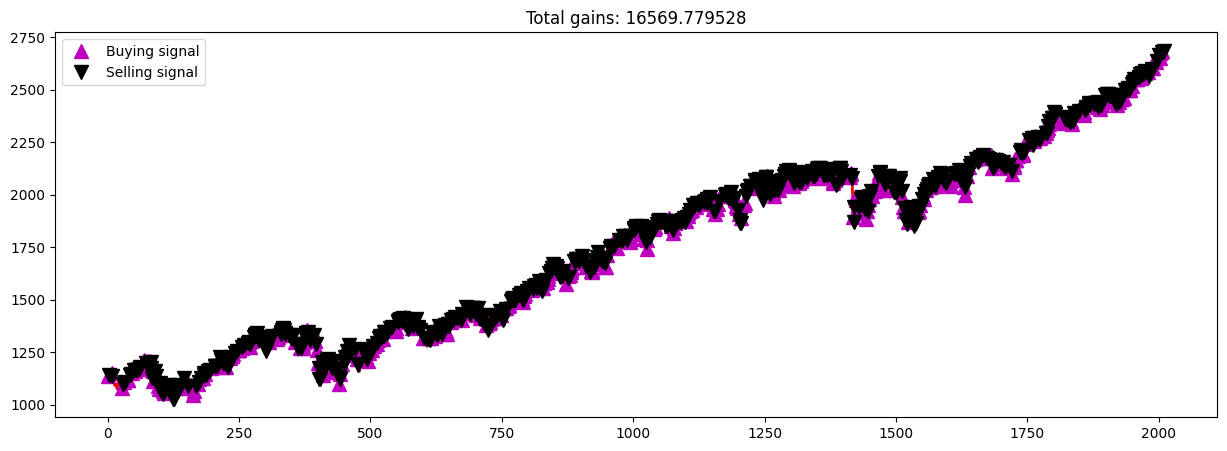

Running episode 83/100
--------------------------------
Total Profit: $15073.15
--------------------------------


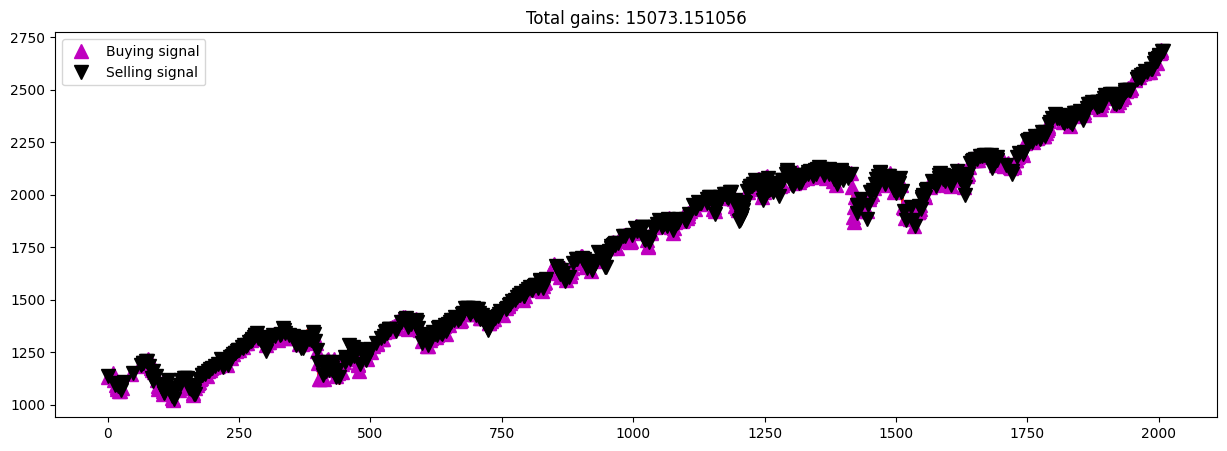

Running episode 84/100
--------------------------------
Total Profit: $11579.28
--------------------------------


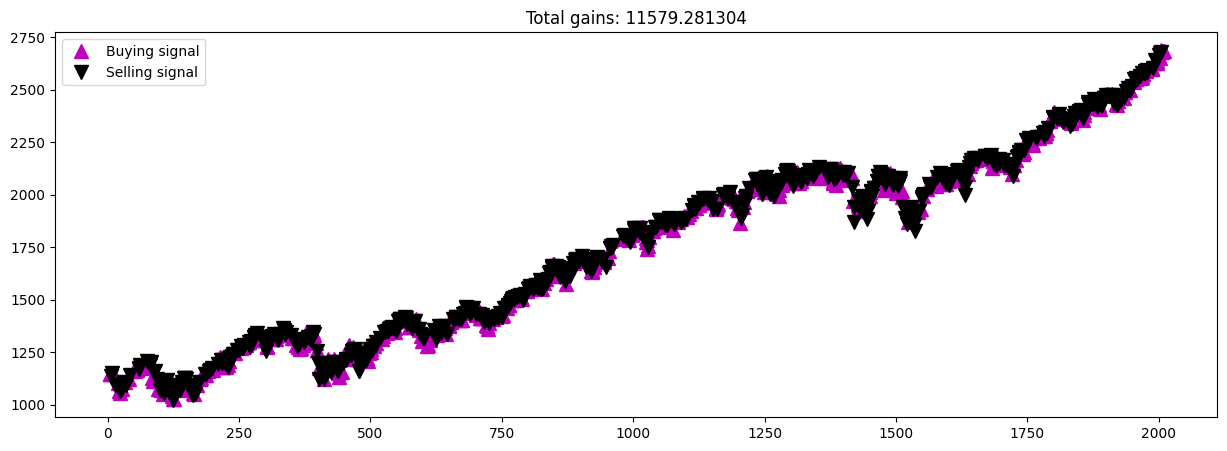

Running episode 85/100
--------------------------------
Total Profit: $21718.97
--------------------------------


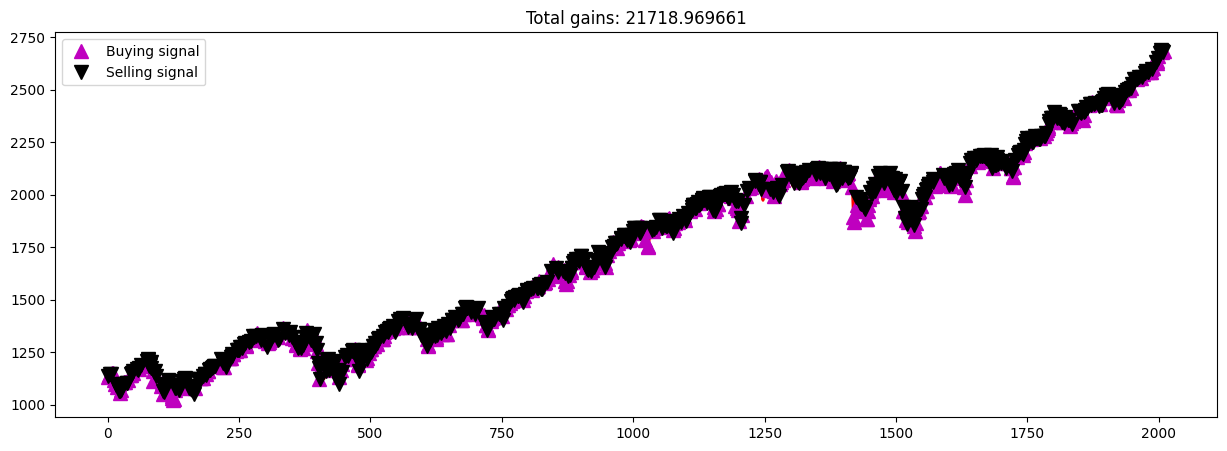

Running episode 86/100
--------------------------------
Total Profit: $22212.36
--------------------------------


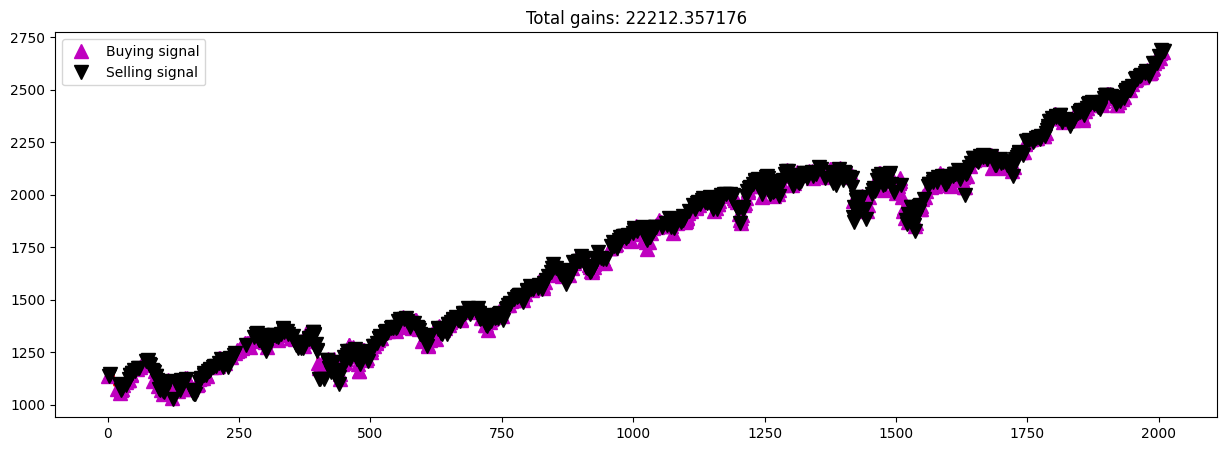

Running episode 87/100
--------------------------------
Total Profit: $34252.36
--------------------------------


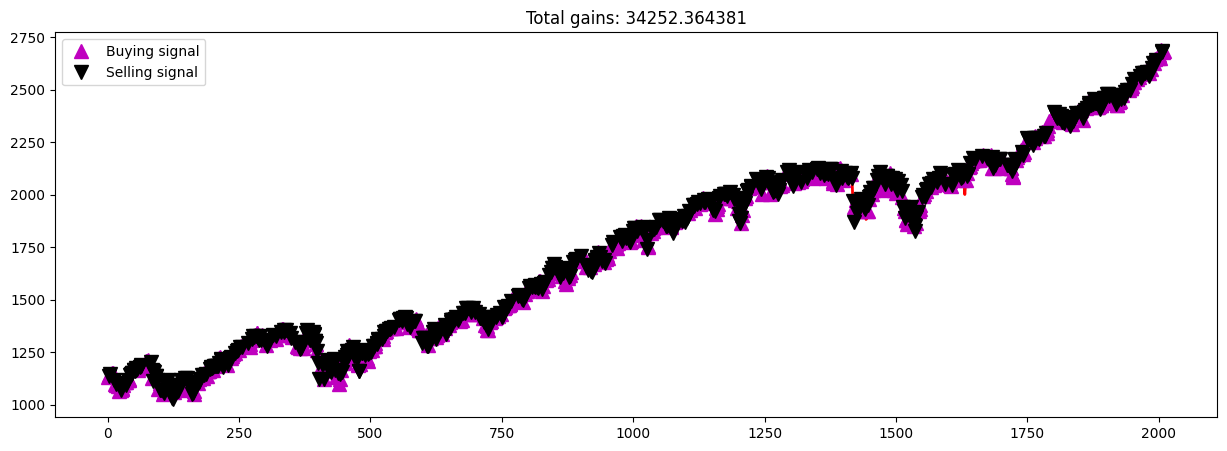

Running episode 88/100
--------------------------------
Total Profit: $2714.95
--------------------------------


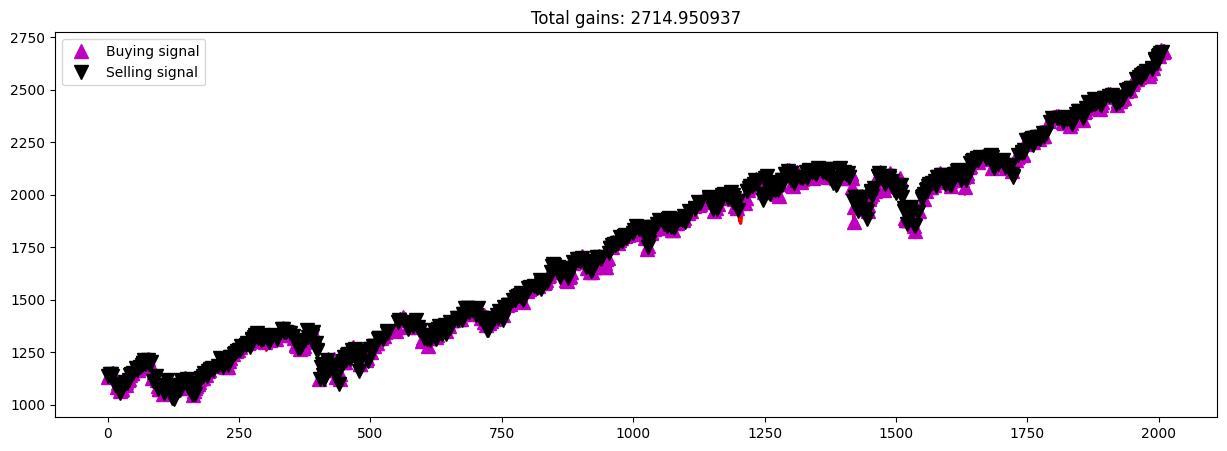

Running episode 89/100
--------------------------------
Total Profit: $12460.65
--------------------------------


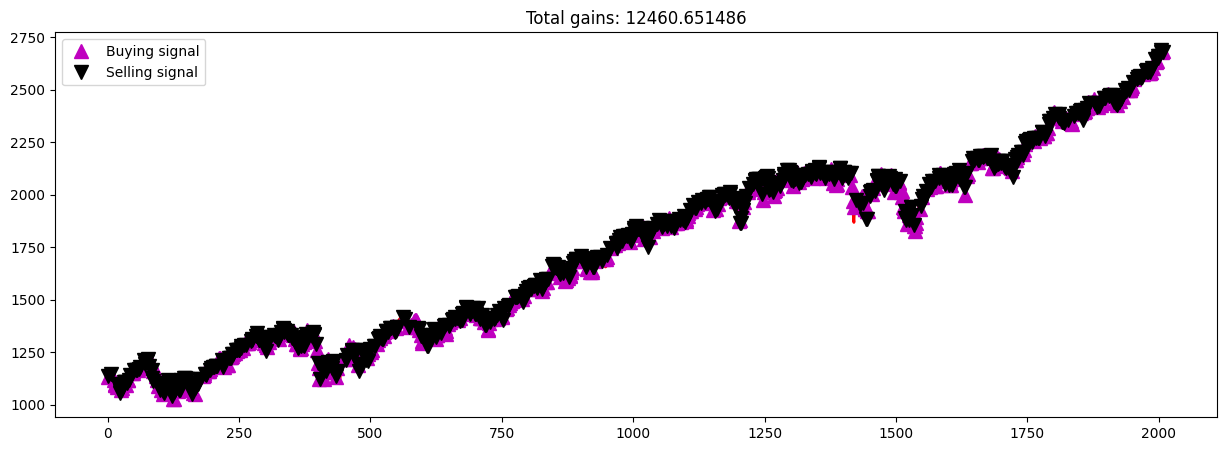

Running episode 90/100
--------------------------------
Total Profit: $47985.70
--------------------------------


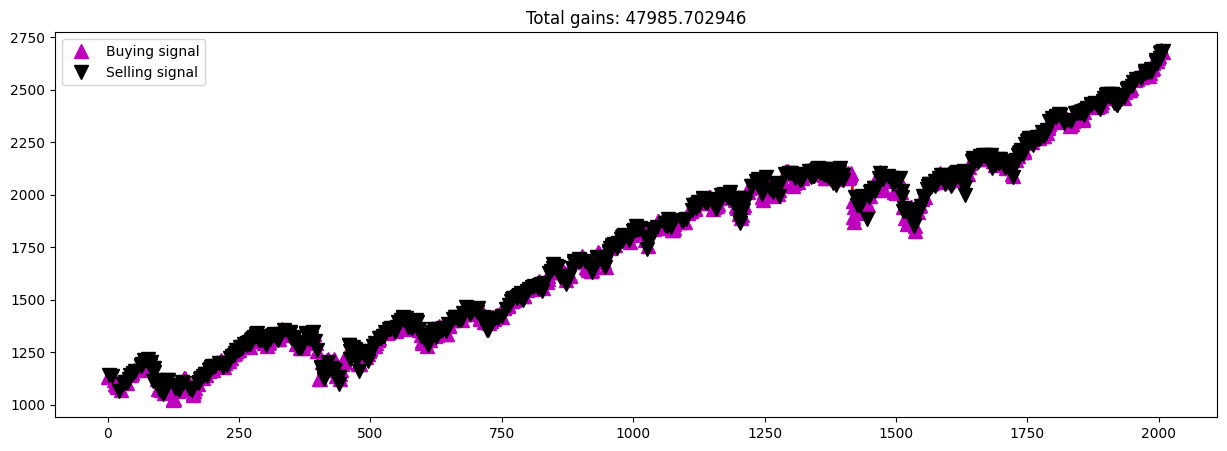

Running episode 91/100
--------------------------------
Total Profit: $19745.69
--------------------------------


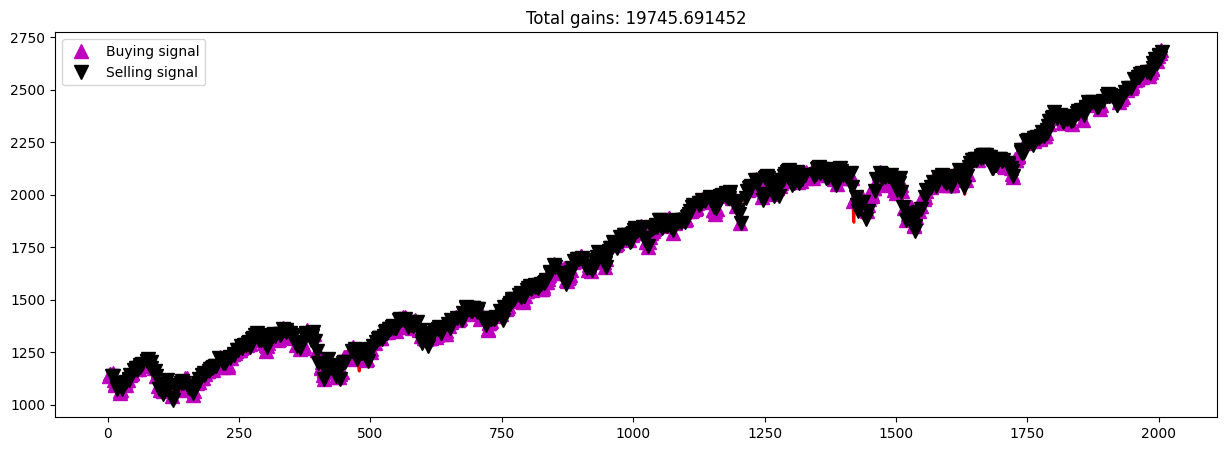

Running episode 92/100
--------------------------------
Total Profit: $26585.91
--------------------------------


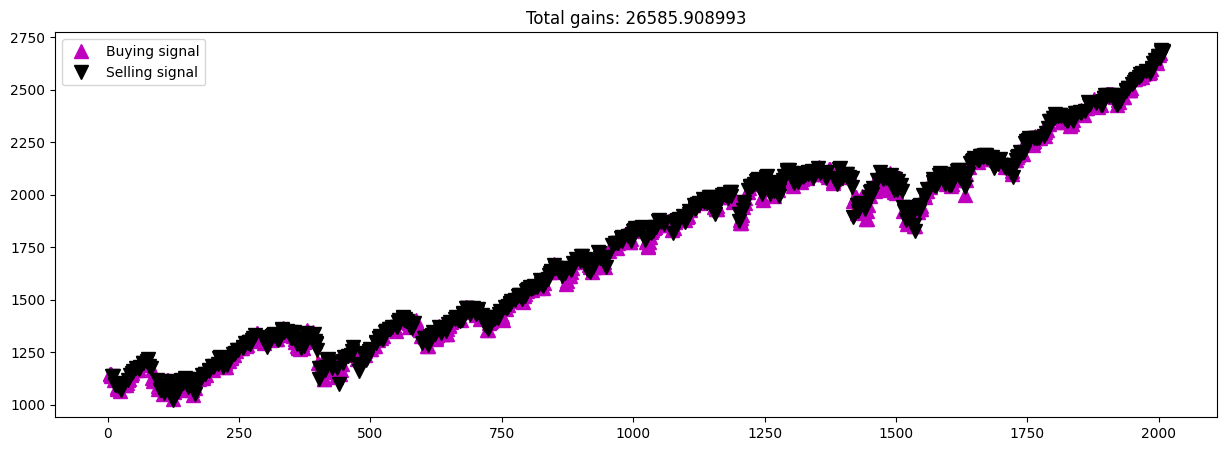

Running episode 93/100
--------------------------------
Total Profit: $20249.97
--------------------------------


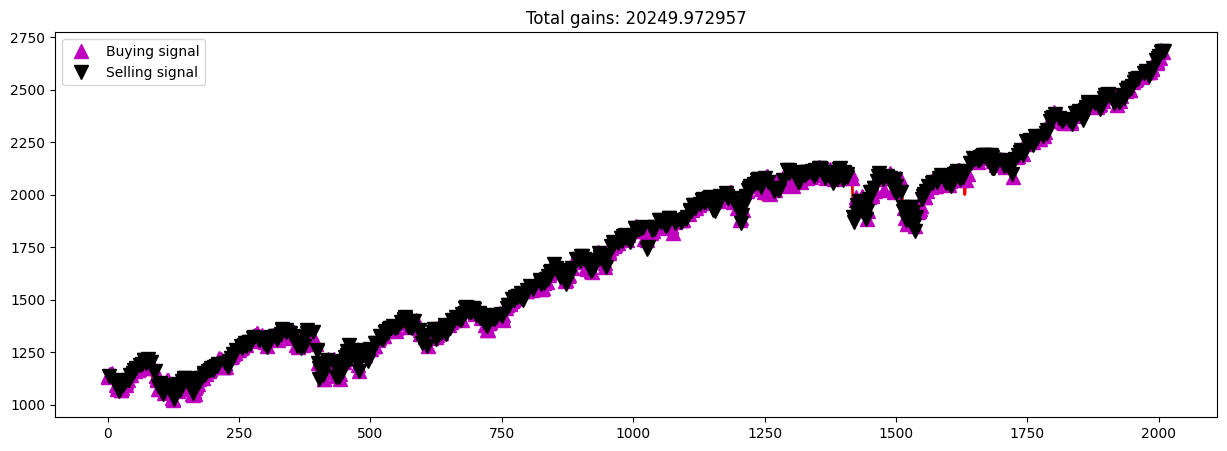

Running episode 94/100
--------------------------------
Total Profit: $50474.68
--------------------------------


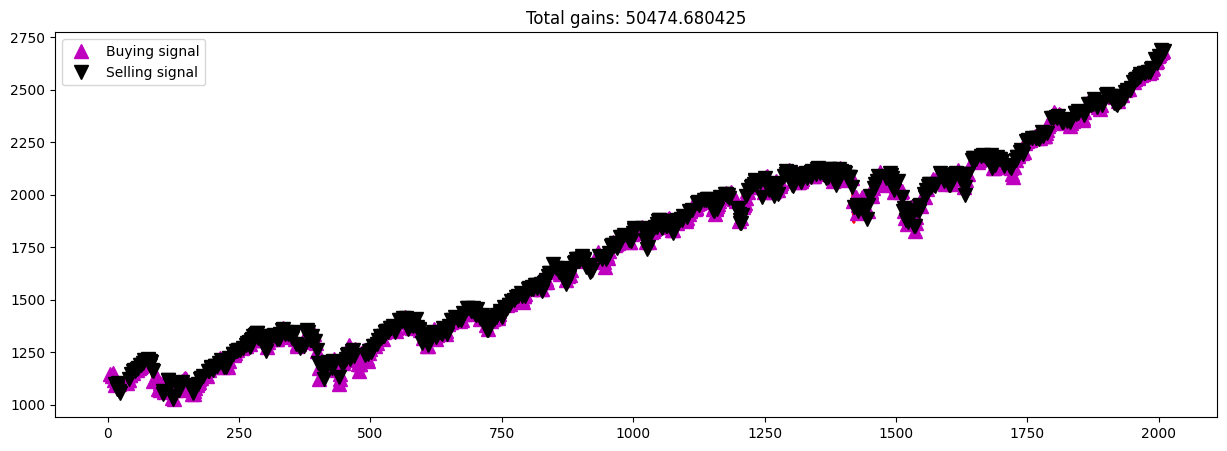

Running episode 95/100
--------------------------------
Total Profit: $22505.97
--------------------------------


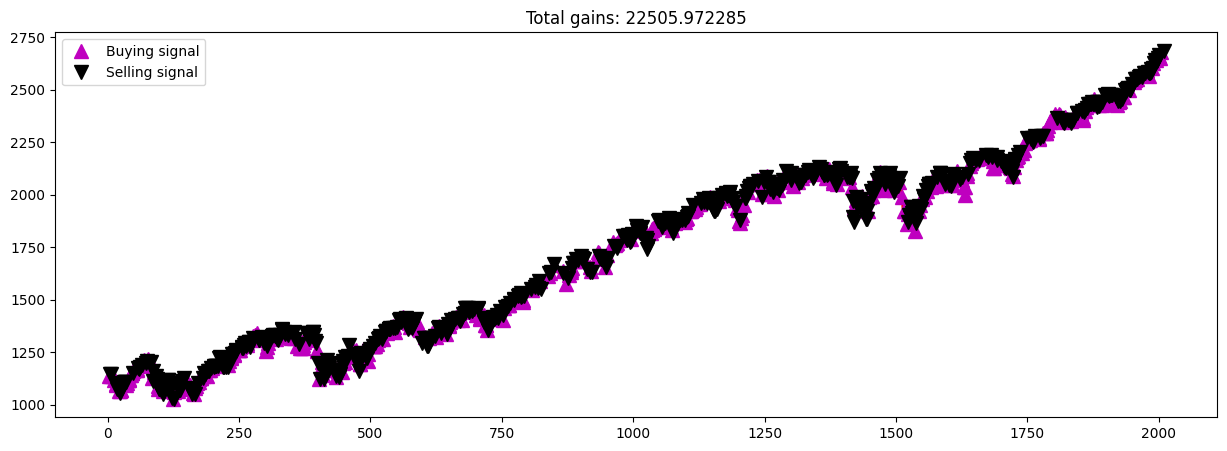

Running episode 96/100
--------------------------------
Total Profit: $44763.00
--------------------------------


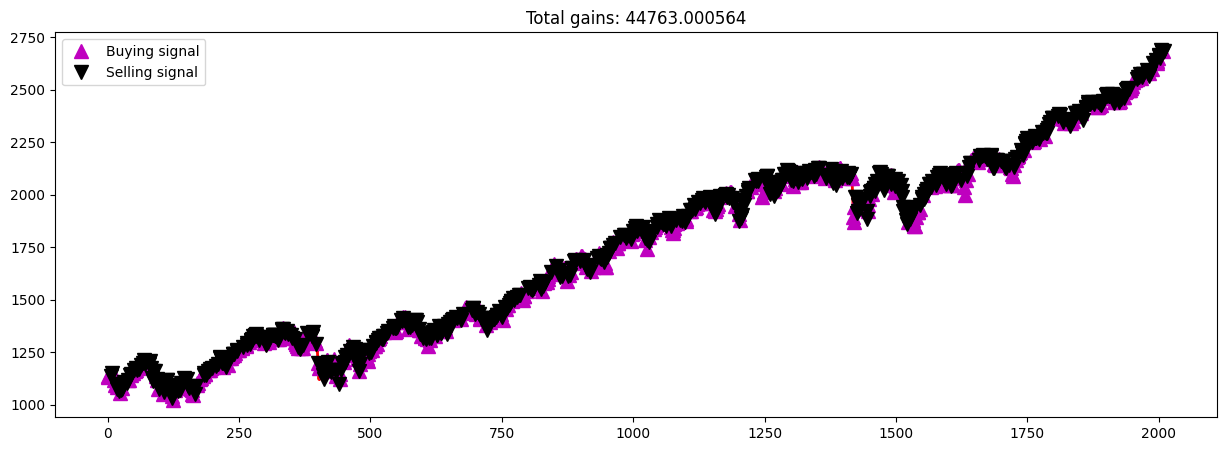

Running episode 97/100
--------------------------------
Total Profit: $39114.81
--------------------------------


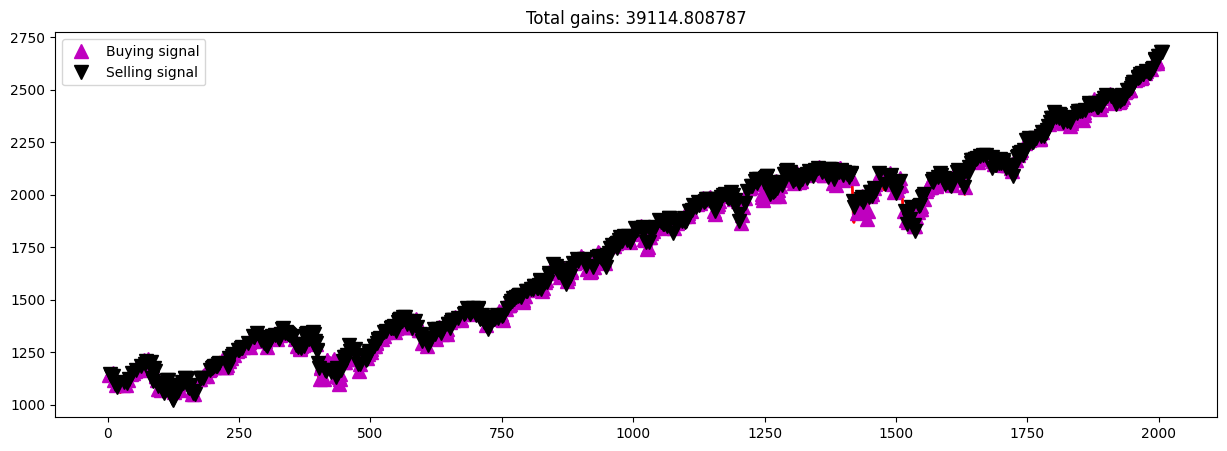

Running episode 98/100
--------------------------------
Total Profit: $34463.17
--------------------------------


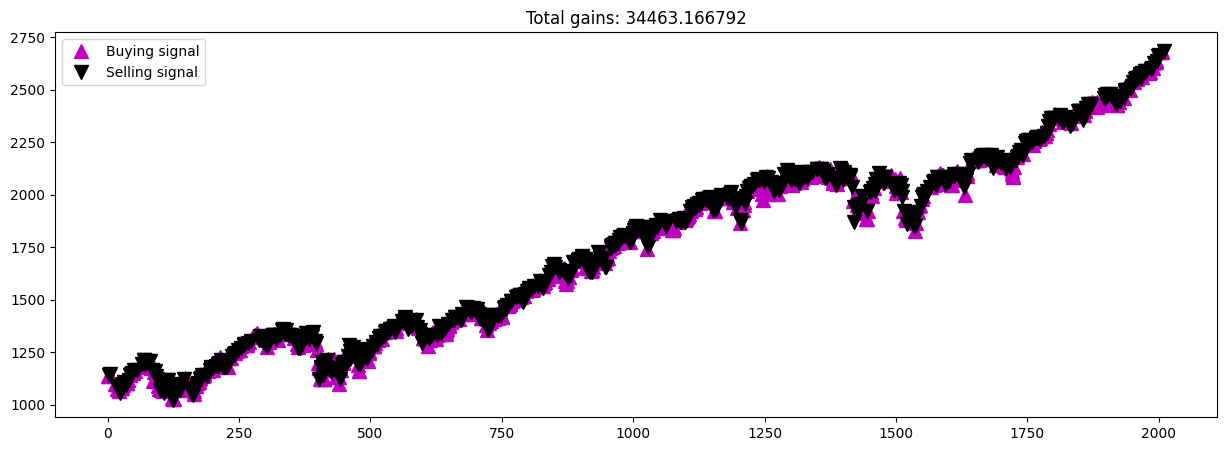

Running episode 99/100
--------------------------------
Total Profit: $24021.20
--------------------------------


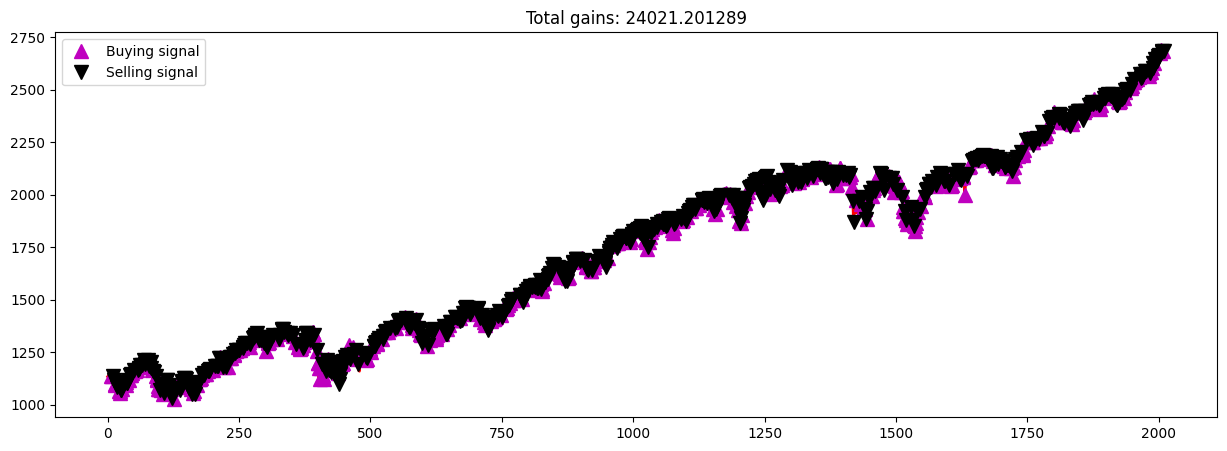

Running episode 100/100
--------------------------------
Total Profit: $21683.95
--------------------------------


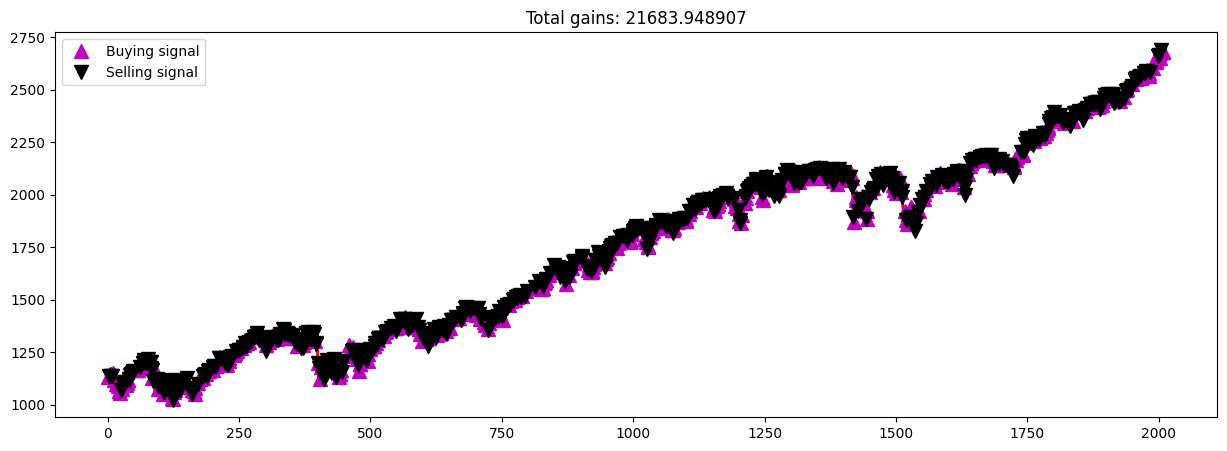

In [16]:
#training

window_size = 10
agent = Agent(window_size)
#In this step we feed the closing value of the stock price
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 100

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1) #agent observes current state
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    #selects an action based on current state
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each
            plot_behavior(data,states_buy, states_sell, total_profit)
#         if len(agent.memory) > batch_size:
#             agent.expReplay(batch_size)

#after each episode, the model is saved every two episodes
#to track the training progress and potentially restore the model later.
    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

In [18]:
#Q-Learning Model
print(agent.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 3075 (12.01 KB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Testing

In [19]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)  #Initializes the state by calling the getState function with the test data, starting at index 0, and a window size of window_size + 1
total_profit = 0  #initilaize profit
is_eval = True    #Indicates that the agent is in evaluation mode.
done = False       # Indicates whether the evaluation is complete or not.
#Initialize empty lists to store the indices where the agent decides to sell or buy during evaluation.
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = [] #Resets the agent's inventory for evaluation.

In [20]:
#Sharpe ratio based on the test data and total profit.
def calculate_sharpe_ratio(data, total_profit):
    # Calculate daily returns
    daily_returns = np.diff(data) / data[:-1]

    # Calculate average daily return and standard deviation of daily return
    avg_daily_return = np.mean(daily_returns)
    std_daily_return = np.std(daily_returns)

    # Assuming risk-free rate is 0 for simplicity
    risk_free_rate = 0

    # Calculate Sharpe ratio
    sharpe_ratio = (avg_daily_return - risk_free_rate) / std_daily_return

    return sharpe_ratio

# trading simualtion

•	A loop iterates over each data point in the test data.

•	At each time step:
1.	The agent's action is determined using the current state.
2.	Based on the action, the agent may buy, sell, or hold.
3.	The reward is calculated based on the action taken.
4.	Metrics such as total profit, number of trades, and winning trades are updated accordingly.
5.	The state, action, reward, and next state are appended to the agent's memory.
6.	If it's the last time step, done is set to True.





1/1 [==============================] - 0s 126ms/step
Buy: $2673.61
1/1 [==============================] - 0s 19ms/step
Buy: $2695.81
1/1 [==============================] - 0s 26ms/step
Buy: $2713.06
1/1 [==============================] - 0s 22ms/step
Buy: $2723.99
1/1 [==============================] - 0s 22ms/step
Buy: $2743.15
1/1 [==============================] - 0s 21ms/step
Buy: $2747.71
1/1 [==============================] - 0s 22ms/step
Buy: $2751.29
1/1 [==============================] - 0s 22ms/step
Buy: $2748.23
1/1 [==============================] - 0s 33ms/step
Buy: $2767.56
1/1 [==============================] - 0s 28ms/step
Buy: $2786.24
1/1 [==============================] - 0s 29ms/step
Buy: $2776.42
1/1 [==============================] - 0s 35ms/step
Buy: $2802.56
1/1 [==============================] - 0s 33ms/step
Buy: $2798.03
1/1 [==============================] - 0s 33ms/step
Buy: $2810.30
1/1 [==============================] - 0s 35ms/step
Buy: $2832.97
1/1 [====

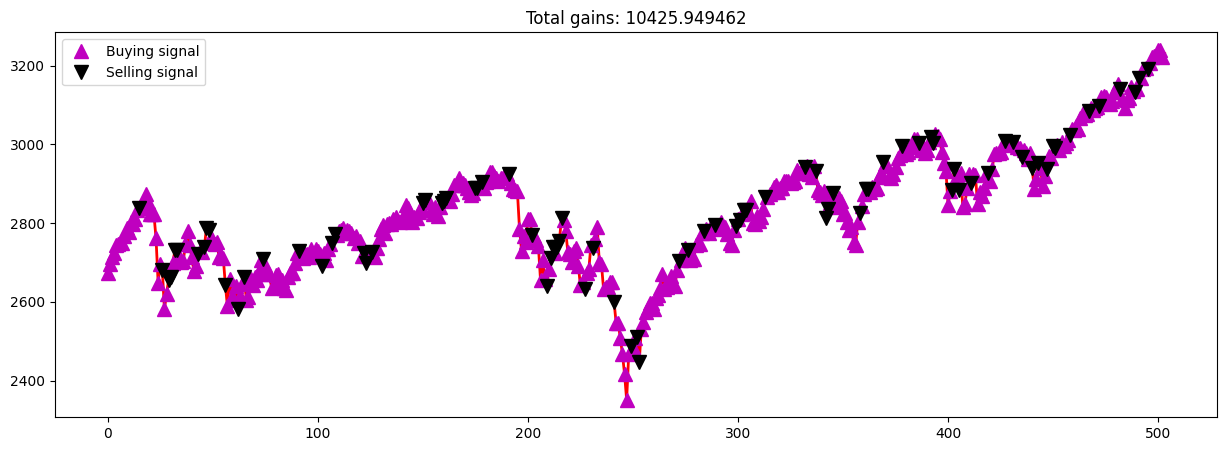

In [21]:
# Define variables to track metrics
total_profit = 0
sharpe_ratio = 0
win_rate = 0
baseline_profit = 0
baseline_sharpe_ratio = 0
baseline_win_rate = 0
num_trades = 0
num_winning_trades = 0

# Define lists to store trade information
states_sell_test = []
states_buy_test = []

# Iterate over the test data
for t in range(l_test):
    # Get the agent's action
    action = agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    # Buy action
    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    # Sell action
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price

        # Update trade metrics
        num_trades += 1
        if reward > 0:
            num_winning_trades += 1

        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    # Update agent's memory
    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

# Calculate metrics
# Total profit
total_profit = total_profit

# Sharpe ratio
# Assuming risk-free rate is 0 for simplicity
# You may need to adjust this calculation based on your specific context
sharpe_ratio = calculate_sharpe_ratio(test_data, total_profit)

# Win rate
win_rate = num_winning_trades / num_trades if num_trades > 0 else 0

# Comparison with baseline strategy
# Define a baseline strategy (e.g., buy and hold)
baseline_profit = test_data[-1] - test_data[0]  # Profit from buy and hold strategy
baseline_sharpe_ratio = 0  # Adjust this based on your risk-free rate
baseline_win_rate = 0  # No trades in the baseline strategy

# # Print baseline metrics
# print("Baseline Profit: " + formatPrice(baseline_profit))
# print("Baseline Sharpe Ratio: " + str(baseline_sharpe_ratio))
# print("Baseline Win Rate: " + str(baseline_win_rate))

# Print metrics
print("------------------------------------------")
print("Total Profit: " + formatPrice(total_profit))
print("Sharpe Ratio: " + str(sharpe_ratio))
print("Win Rate: " + str(win_rate))
print("Baseline Profit: " + formatPrice(baseline_profit))
print("Baseline Sharpe Ratio: " + str(baseline_sharpe_ratio))
print("Baseline Win Rate: " + str(baseline_win_rate))
print("------------------------------------------")

# Plot behavior
plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)
